# Measurement metrics result analysis

In [382]:
# Imports
import json
import os, sys
import csv 
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
import numpy as np
import dataframe_image as dfi
a4_dims = (11.7, 8.27)
palette = sns.color_palette('colorblind', 10)
palette = sns.color_palette('Paired', 10)
sns.set_style("whitegrid")


In [383]:
def json_to_dict(path):
    """
    Helper function
    :param path: Path to json file
    :return: dictionary with json content
    """
    with open(path) as json_file:
        data = json.load(json_file)
    return data

In [384]:
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

path_csv = os.path.join(parent_dir,"outputs", "data", "small_sample.csv")
raw_csv = open(path_csv, encoding="utf-8-sig")
reader = csv.reader(raw_csv, delimiter=";")
content_list = list(reader)
repo_sample_df = pd.DataFrame(content_list[1:],columns=content_list[0])
path_metrics = os.path.join(parent_dir,"outputs", "results", "csv_metrics.json")
path_repository = os.path.join(parent_dir,"outputs", "data", "csv_repository.json")
metrics_dict = json_to_dict(path=path_metrics)
repository_dict = json_to_dict(path=path_repository)

In [385]:
def get_metrics(metrics, metrics_dict=metrics_dict, repository_dict=repository_dict, png_filename="", study=""):
    result = {}
    if study:
        repo_study_df = repo_sample_df[repo_sample_df['study'].str.contains(study)]
    else:
        repo_study_df = repository_dict
    for metric, info in metrics.items():
        print(metric)
        if isinstance(info, list):
            for info_elem in info:
                value_list = []
                repo_list = []
                metric_key = info_elem
                for repo, item in repository_dict.items():
                    name = item.get("name")
                    if isinstance(metrics_dict, dict) and metric != "security_advisories":
                        try:
                            value = metrics_dict.get(metric).get(repo).get(info_elem)
                        except AttributeError as attr_err:
                            # print(metric)
                            # print(repo)
                            # print(f"AttributeError: {attr_err}")
                            pass        
                    else:
                        value = metrics_dict.get(metric)[0].get(repo).get(info_elem)
                        # print(metrics_dict.get(metric).get(repo))
                    if study and name in repo_study_df["repository"].values:
                        login = item.get("owner").get("login")
                        repo_list.append((name + "_" + login))
                        value_list.append(value)
                    elif not study:
                        login = item.get("owner").get("login")
                        repo_list.append((name + "_" + login))
                        value_list.append(value)
                result["repository"] = repo_list        
                result[metric_key] = value_list
        else:
            value_list = []
            repo_list = []
            if info:
                metric_key = info
            else:
                metric_key = metric
            
            for repo, item in repository_dict.items():
                name = item.get("name")
                if info:
                    value = metrics_dict.get(metric).get(repo).get(info)
                else:
                    value = metrics_dict.get(metric).get(repo)
                if study and name in repo_study_df["repository"].values:
                    login = item.get("owner").get("login")
                    repo_list.append((name + "_" + login))
                    value_list.append(value)
                elif not study:
                    login = item.get("owner").get("login")
                    repo_list.append((name + "_" + login))
                    value_list.append(value)
            result["repository"] = repo_list        
            result[metric_key] = value_list
        
    df = pd.DataFrame.from_dict(result)
    if png_filename:
        df.dfi.export(png_filename)
    return df


In [358]:
maturity = metrics_dict.get("maturity_level")
size_of_community = metrics_dict.get("size_of_community")
star_maturity_dict = {}
repo_list = []
star_list = []
sub_list = []
open_issues_list = []
forks_count_list = []
maturity_list = []
size_of_community_list = []
for repo, item in repository_dict.items():
    name = item.get("name")
    login = item.get("owner").get("login")
    repo_list.append((name + "_" + login))
    star_list.append(item.get("stargazers_count"))
    maturity_list.append(maturity.get(repo))
    size_of_community_list.append(size_of_community.get(repo))
    sub_list.append(item.get("subscribers_count"))
    open_issues_list.append(item.get("open_issues"))
    forks_count_list.append(item.get("forks_count"))
# star_maturity_dict["Repository"] = repo_list
star_maturity_dict["MaturityScore"] = maturity_list
star_maturity_dict["SizeOfCommunity"] = size_of_community_list
star_maturity_dict["Stargazers"] = star_list
star_maturity_dict["SubscribersCount"] = sub_list
star_maturity_dict["OpenIssuesCount"] = open_issues_list
star_maturity_dict["ForksCount"] = forks_count_list
df = pd.DataFrame.from_dict(star_maturity_dict)
df.corr()
# df = pd.melt(df, id_vars="Repository", var_name="Objective", value_name="Value")


MaturityScore  SizeOfCommunity  Stargazers  \
MaturityScore          1.000000        -0.393246   -0.184531   
SizeOfCommunity       -0.393246         1.000000    0.356169   
Stargazers            -0.184531         0.356169    1.000000   
SubscribersCount      -0.189055         0.352792    0.941976   
OpenIssuesCount       -0.147816         0.248756    0.486416   
ForksCount            -0.232757         0.338651    0.878402   

                  SubscribersCount  OpenIssuesCount  ForksCount  
MaturityScore            -0.189055        -0.147816   -0.232757  
SizeOfCommunity           0.352792         0.248756    0.338651  
Stargazers                0.941976         0.486416    0.878402  
SubscribersCount          1.000000         0.331020    0.937409  
OpenIssuesCount           0.331020         1.000000    0.291459  
ForksCount                0.937409         0.291459    1.000000

## Small Sample

In [386]:
metrics = {
    "maturity_level": None,
    "osi_approved_license": None,
    "criticality_score":None,
    "technical_fork": ["total_forks", "forks_contributed", "forks_not_contributed", "forks_contributed_ratio", "forks_not_contributed_ratio", "average_forks_created_per_week"],
    "pull_requests": ["total_pulls", "avg_pull_closing_days", "ratio_open_total", "ratio_closed_total", "ratio_merged_total"],
    "project_velocity": ["total_issues", "closed_issues", "open_issues", "pull_count", "no_pull_count", "ratio_pull_issue", "avg_issue_resolving_days", "ratio_open_total", "ratio_closed_total"],
    "github_community_health_percentage": ["community_health_score","custom_health_score", "true_count", "false_count", "description", "documentation", "code_of_conduct",
                                          "contributing", "issue_template", "pull_request_template", "license", "readme"],
    "issues": ["total_issues", "open_issues", "closed_issues", "new_issues", "new_ratio", "average_issues_created_per_week", "average_issue_comments", "average_issue_resolving_days",
              "average_first_response_time_days", "ratio_open_total", "ratio_closed_total"],
    "support_rate": None,
    "code_dependency": ["total_upstream", "total_downstream", "visible_downstream"],
    "security_advisories": ["advisories_available", "patch_ratio", "closed_advisories", "average_cvss_score", "ratio_severity_high_crit"],
    "contributions_distributions": ["bus_factor_score", "RoC_twenty_percent", "RoC_eighty_percent_soll", "RoC_eighty_percent_ist", "RoC_diff_pareto_soll_ist_percent", "avg_num_contributors_per_file",
                                    "NoC_twenty_percent", "NoC_eighty_percent_soll", "NoC_eighty_percent_ist", "NoC_diff_pareto_soll_ist_percent"],
    "number_of_support_contributors": None,
    "elephant_factor": None,
    "size_of_community": None,
    "churn": None,
    "branch_lifecycle": ["branch_creation_frequency_days", "branch_avg_age_days", "stale_ratio", "active_ratio", "unresolved_ratio", "resolved_ratio", "branch_state_counter"]
}

In [387]:
total_small_sample = get_metrics(metrics=metrics)

maturity_level
osi_approved_license
criticality_score
technical_fork
pull_requests
project_velocity
github_community_health_percentage
issues
support_rate
code_dependency
security_advisories
contributions_distributions
number_of_support_contributors
elephant_factor
size_of_community
churn
branch_lifecycle


### OSI approved license

In [390]:
repo_small = total_small_sample [["repository", "osi_approved_license"]]
png_filename = "small_sample_repository_metrics.png"
# repo_small.dfi.export(png_filename)
repo_small_head = repo_small.head(20)
png_filename = "small_sample_repository_metrics_top20.png"
repo_small_summary = repo_small['osi_approved_license'].describe()
repo_small_summary = repo_small_summary
# repo_small_head.dfi.export(png_filename)
repo_small_summary.to_frame().transpose()

count unique           top freq
osi_approved_license     6      1  not_provided    6

In [393]:
    import requests
    url = ("https://raw.githubusercontent.com/" +
    "spdx/license-list-data/master/json/licenses.json")
    response = requests.get(url, timeout=100)
    results_dict = response.json().get("licenses")
    print(results_dict)

[{'reference': 'https://spdx.org/licenses/0BSD.html', 'isDeprecatedLicenseId': False, 'detailsUrl': 'https://spdx.org/licenses/0BSD.json', 'referenceNumber': 127, 'name': 'BSD Zero Clause License', 'licenseId': '0BSD', 'seeAlso': ['http://landley.net/toybox/license.html', 'https://opensource.org/licenses/0BSD'], 'isOsiApproved': True}, {'reference': 'https://spdx.org/licenses/AAL.html', 'isDeprecatedLicenseId': False, 'detailsUrl': 'https://spdx.org/licenses/AAL.json', 'referenceNumber': 121, 'name': 'Attribution Assurance License', 'licenseId': 'AAL', 'seeAlso': ['https://opensource.org/licenses/attribution'], 'isOsiApproved': True}, {'reference': 'https://spdx.org/licenses/Abstyles.html', 'isDeprecatedLicenseId': False, 'detailsUrl': 'https://spdx.org/licenses/Abstyles.json', 'referenceNumber': 329, 'name': 'Abstyles License', 'licenseId': 'Abstyles', 'seeAlso': ['https://fedoraproject.org/wiki/Licensing/Abstyles'], 'isOsiApproved': False}, {'reference': 'https://spdx.org/licenses/Ad

### Churn

In [237]:
churn_small = total_small_sample [["repository", "churn"]]
png_filename = "small_sample_churn_metrics.png"
# churn_small.dfi.export(png_filename)
churn_small_head = churn_small.head(20)
png_filename = "small_sample_churn_metrics_top20.png"
# churn_small_head.dfi.export(png_filename)
churn_summary = churn_small['churn'].describe()
churn_summary = churn_summary
churn_summary = churn_summary.to_frame().transpose()
churn_summary.dfi.export("small_sample_churn_description.png")
# print(churn_summary) #.to_csv("small_sample_churn_description.csv")

### Branches

In [245]:
branches_small = total_small_sample [["repository", "branch_state_counter", "branch_creation_frequency_days", "branch_avg_age_days", "stale_ratio", "active_ratio", "unresolved_ratio", "resolved_ratio"]]
png_filename = "small_sample_branches_metrics.png"
# branches_small.dfi.export(png_filename)
branches_small_head = branches_small.head(20)
# png_filename = "small_sample_branches_metrics_top20.png"
# branches_small_head.dfi.export(png_filename)

branches_small_summary = branches_small[["branch_state_counter", "branch_creation_frequency_days", "branch_avg_age_days", "stale_ratio", "active_ratio", "unresolved_ratio", "resolved_ratio"]].describe()
branches_small_summary = branches_small_summary.transpose()
branches_small_summary.dfi.export("small_sample_branches_description.png")

### Contributions Distributions

In [101]:
total_small_sample [["repository", "bus_factor_score", "elephant_factor", "RoC_twenty_percent", "RoC_eighty_percent_soll", "RoC_eighty_percent_ist", "RoC_diff_pareto_soll_ist_percent", "avg_num_contributors_per_file",
                                    "NoC_twenty_percent", "NoC_eighty_percent_soll", "NoC_eighty_percent_ist", "NoC_diff_pareto_soll_ist_percent"]]

repository  bus_factor_score  \
0                              ipscan_angryip               NaN   
1                             Ditto_sabrogden               NaN   
2                       eclipse-cs_checkstyle               1.0   
3                        firebird_FirebirdSQL               4.0   
4                                     git_git               4.0   
5                               gparted_GNOME               1.0   
6                     hibernate-orm_hibernate               2.0   
7                  HPCC-Platform_hpcc-systems               2.0   
8                                  kdiff3_KDE               1.0   
9                 libjpeg-turbo_libjpeg-turbo               1.0   
10                             linux_torvalds             172.0   
11                  MediaPortal-1_MediaPortal               1.0   
12                MediathekView_mediathekview               1.0   
13              moneymanagerex_moneymanagerex               1.0   
14                              moodle_moodle               5.0   
15               nagioscore_NagiosEnterprises               1.0   
16                             naps2_cyanfish               1.0   
17                          net-snmp_net-snmp               1.0   
18                   PythonScript_bruderstein               2.0   
19                      pandorafms_pandorafms               7.0   
20                              pwsafe_pwsafe               1.0   
21                                    pmd_pmd               2.0   
22                                  ruby_ruby               5.0   
23                                rails_rails               6.0   
24                     scribus_scribusproject               1.0   
25                            glew_nigels-com               1.0   
26                      unetbootin_unetbootin               1.0   
27  UniversalMediaServer_UniversalMediaServer               1.0   
28                           wine_wine-mirror               7.0   
29                        WordPress_WordPress               2.0   
30                            xcat-core_xcat2               2.0   
31                       Pillow_python-pillow               2.0   
32                                  qemu_qemu              13.0   
33                            openemr_openemr               3.0   
34                              Piwigo_Piwigo               1.0   
35                          glpi_glpi-project               3.0   
36                          jenkins_jenkinsci               3.0   
37                              hhvm_facebook               7.0   
38                          dolibarr_Dolibarr               1.0   
39                              FFmpeg_FFmpeg               4.0   
40                                zulip_zulip               6.0   
41                     BigTree-CMS_bigtreecms               1.0   
42                          postgres_postgres               4.0   
43                                  ceph_ceph              16.0   
44                           samba_samba-team               3.0   
45                 jackson-databind_FasterXML               1.0   
46                              django_django               9.0   
47                            openssl_openssl               4.0   
48                         clamav_Cisco-Talos               1.0   
49                            xen_xen-project               6.0   
50                      phpmyadmin_phpmyadmin               2.0   
51                              suricata_OISF               2.0   
52                        wireshark_wireshark               5.0   
53                              mongo_mongodb              46.0   
54                       TypeScript_microsoft               4.0   
55                                swift_apple              12.0   
56                           vscode_microsoft               8.0   
57                            grafana_grafana              32.0   
58                      tensorflow_tensorflow              20.0   
59             

### Security Advisories

In [252]:
advisories_small_sample = total_small_sample [["repository", "advisories_available", "patch_ratio", "closed_advisories", "average_cvss_score", "ratio_severity_high_crit"]]
# png_filename = "small_sample_advisories_metrics.png"
# advisories_small_sample.dfi.export(png_filename)
# advisories_small_sample_head = advisories_small_sample.head(20)
# png_filename = "small_sample_advisories_metrics_top20.png"
# advisories_small_sample_head.dfi.export(png_filename)

advisories_small_summary = advisories_small_sample[["advisories_available", "patch_ratio", "closed_advisories", "average_cvss_score", "ratio_severity_high_crit"]].describe()
advisories_small_summary = advisories_small_summary.transpose()
advisories_small_summary.dfi.export("small_sample_advisories_description.png")

### Code Dependency

In [389]:
total_small_sample [["repository", "total_upstream", "total_downstream", "visible_downstream"]]

repository  total_upstream  \
0                              ipscan_angryip               4   
1                             Ditto_sabrogden               2   
2                       eclipse-cs_checkstyle              36   
3                        firebird_FirebirdSQL              11   
4                                     git_git              11   
5                               gparted_GNOME               0   
6                     hibernate-orm_hibernate              19   
7                  HPCC-Platform_hpcc-systems             944   
8                                  kdiff3_KDE               0   
9                 libjpeg-turbo_libjpeg-turbo               2   
10                             linux_torvalds               4   
11                  MediaPortal-1_MediaPortal              40   
12                MediathekView_mediathekview              71   
13              moneymanagerex_moneymanagerex               1   
14                              moodle_moodle             189   
15               nagioscore_NagiosEnterprises               0   
16                             naps2_cyanfish              58   
17                          net-snmp_net-snmp               3   
18                   PythonScript_bruderstein               7   
19                      pandorafms_pandorafms             785   
20                              pwsafe_pwsafe               6   
21                                    pmd_pmd             399   
22                                  ruby_ruby             129   
23                                rails_rails            1052   
24                     scribus_scribusproject               1   
25                            glew_nigels-com               0   
26                      unetbootin_unetbootin              49   
27  UniversalMediaServer_UniversalMediaServer            1508   
28                           wine_wine-mirror               0   
29                        WordPress_WordPress            1577   
30                            xcat-core_xcat2              18   
31                       Pillow_python-pillow              11   
32                                  qemu_qemu               1   
33                            openemr_openemr            1654   
34                              Piwigo_Piwigo               0   
35                          glpi_glpi-project             953   
36                          jenkins_jenkinsci             935   
37                              hhvm_facebook             650   
38                          dolibarr_Dolibarr             124   
39                              FFmpeg_FFmpeg               0   
40                                zulip_zulip            2105   
41                     BigTree-CMS_bigtreecms              43   
42                          postgres_postgres               0   
43                                  ceph_ceph            2230   
44                           samba_samba-team               0   
45                 jackson-databind_FasterXML              30   
46                              django_django              41   
47                            openssl_openssl              15   
48                         clamav_Cisco-Talos             172   
49                            xen_xen-project               2   
50                      phpmyadmin_phpmyadmin             890   
51                              suricata_OISF              14   
52                        wireshark_wireshark              11   
53                              mongo_mongodb              53   
54                       TypeScript_microsoft             369   
55                                swift_apple               0   
56                           vscode_microsoft            2709   
57                            grafana_grafana            3677   
58                      tensorflow_tensorflow             114   
59                                  vue_vuejs            1819   
60                        keystone_keystonejs            2838   
61   

In [98]:
total_small_sample [["repository", "open_issues", "closed_issues", "new_issues", "new_ratio", "average_issues_created_per_week", "average_issue_comments", "average_issue_resolving_days",
              "average_first_response_time_days", "ratio_open_total", "ratio_closed_total"]]

repository  open_issues  closed_issues  \
0                              ipscan_angryip            0              0   
1                             Ditto_sabrogden            0              0   
2                       eclipse-cs_checkstyle            0              0   
3                        firebird_FirebirdSQL            0              0   
4                                     git_git            0              0   
5                               gparted_GNOME            0              0   
6                     hibernate-orm_hibernate            0              0   
7                  HPCC-Platform_hpcc-systems            0              0   
8                                  kdiff3_KDE            0              0   
9                 libjpeg-turbo_libjpeg-turbo            0              0   
10                             linux_torvalds            0              0   
11                  MediaPortal-1_MediaPortal            0              0   
12                MediathekView_mediathekview            0              0   
13              moneymanagerex_moneymanagerex            0              0   
14                              moodle_moodle            0              0   
15               nagioscore_NagiosEnterprises            0              0   
16                             naps2_cyanfish            0              0   
17                          net-snmp_net-snmp            0              0   
18                   PythonScript_bruderstein            0              0   
19                      pandorafms_pandorafms            0              0   
20                              pwsafe_pwsafe            0              0   
21                                    pmd_pmd            0              0   
22                                  ruby_ruby            0              0   
23                                rails_rails            0              0   
24                     scribus_scribusproject            0              0   
25                            glew_nigels-com            0              0   
26                      unetbootin_unetbootin            0              0   
27  UniversalMediaServer_UniversalMediaServer            0              0   
28                           wine_wine-mirror            0              0   
29                        WordPress_WordPress            0              0   
30                            xcat-core_xcat2            0              0   
31                       Pillow_python-pillow            0              0   
32                                  qemu_qemu            0              0   
33                            openemr_openemr            0              0   
34                              Piwigo_Piwigo            0              0   
35                          glpi_glpi-project            0              0   
36                          jenkins_jenkinsci            0              0   
37                              hhvm_facebook            0              0   
38                          dolibarr_Dolibarr            0              0   
39                              FFmpeg_FFmpeg            0              0   
40                                zulip_zulip            0              0   
41                     BigTree-CMS_bigtreecms            0              0   
42                          postgres_postgres            0              0   
43                                  ceph_ceph            0              0   
44                           samba_samba-team            0              0   
45                 jackson-databind_FasterXML            0              0   
46                              django_django            0              0   
47                            openssl_openssl            0              0   
48                         clamav_Cisco-Talos            0              0   
49                            xen_xen-project            0              0   
50                      phpmyadmin_phpmyadmin            0              0   
51                             

### Community Health Score

In [250]:
health_small_sample = total_small_sample [["repository", "community_health_score","custom_health_score", "true_count", "false_count", "description", "documentation", "code_of_conduct",
                                          "contributing", "issue_template", "pull_request_template", "license", "readme"]]
# png_filename = "small_sample_health_metrics.png"
# health_small_sample.dfi.export(png_filename)
# health_small_sample_head = health_small_sample.head(20)
# png_filename = "small_sample_health_metrics_top20.png"
# health_small_sample_head.dfi.export(png_filename)

health_small_summary = health_small_sample[["repository", "community_health_score","custom_health_score"]].describe()
health_small_summary = health_small_summary.transpose()
health_small_summary.dfi.export("small_sample_health_description.png")

In [94]:
total_small_sample [["repository", "total_issues", "closed_issues", "open_issues", "pull_count", "no_pull_count", "ratio_pull_issue", "avg_issue_resolving_days", "ratio_open_total", "ratio_closed_total"]]

total_issues  closed_issues  open_issues  pull_count  no_pull_count  \
0              0              0            0           0              0   
1              0              0            0           0              2   
2              0              0            0           0              1   
3              0              0            0           2              7   
4              0              0            0           4              0   
5              0              0            0           0              0   
6              0              0            0           8              0   
7              0              0            0          15              0   
8              0              0            0           0              0   
9              0              0            0           0              0   
10             0              0            0           1              0   
11             0              0            0           0              0   
12             0              0            0           0              0   
13             0              0            0           0              1   
14             0              0            0           0              0   
15             0              0            0           0              0   
16             0              0            0           0              2   
17             0              0            0           2              1   
18             0              0            0           0              0   
19             0              0            0           0              0   
20             0              0            0           1              1   
21             0              0            0           0              1   
22             0              0            0          24              0   
23             0              0            0          17              3   
24             0              0            0           0              0   
25             0              0            0           0              0   
26             0              0            0           0              0   
27             0              0            0          12              4   
28             0              0            0           0              0   
29             0              0            0           0              0   
30             0              0            0           0              2   
31             0              0            0           3              2   
32             0              0            0           0              0   
33             0              0            0           9              4   
34             0              0            0           0              4   
35             0              0            0          43              8   
36             0              0            0          16              0   
37             0              0            0           1              0   
38             0              0            0          19              7   
39             0              0            0           0              0   
40             0              0            0          18              6   
41             0              0            0           1              2   
42             0              0            0           0              0   
43             0              0            0          36              0   
44             0              0            0           0              0   
45             0              0            0           4              1   
46             0              0            0          12              0   
47             0              0            0          19             10   
48             0              0            0           7              0   
49             0              0            0           0              0   
50             0              0            0           2              1   
51             0              0            0           3              0   
52             0             

In [93]:
total_small_sample [["repository", "total_pulls", "avg_pull_closing_days", "ratio_open_total", "ratio_closed_total", "ratio_merged_total"]]

total_pulls  avg_pull_closing_days ratio_open_total ratio_closed_total  \
0             0                    NaN             None               None   
1             0                    NaN             None               None   
2             0                    NaN             None               None   
3             2               5.000000             None               None   
4             4                    NaN             None               None   
5             0                    NaN             None               None   
6             8                    NaN             None               None   
7            15               3.285714             None               None   
8             0                    NaN             None               None   
9             0                    NaN             None               None   
10            0                    NaN             None               None   
11            0                    NaN             None               None   
12            0                    NaN             None               None   
13            0                    NaN             None               None   
14            0                    NaN             None               None   
15            0                    NaN             None               None   
16            0                    NaN             None               None   
17            2               0.000000             None               None   
18            0                    NaN             None               None   
19            0                    NaN             None               None   
20            1               0.000000             None               None   
21            0                    NaN             None               None   
22           24               3.352941             None               None   
23           17               0.777778             None               None   
24            0                    NaN             None               None   
25            0                    NaN             None               None   
26            0                    NaN             None               None   
27           11               3.714286             None               None   
28            0                    NaN             None               None   
29            0                    NaN             None               None   
30            0                    NaN             None               None   
31            3              13.000000             None               None   
32            0                    NaN             None               None   
33            9               2.000000             None               None   
34            0                    NaN             None               None   
35           47              13.250000             None               None   
36           16               0.250000             None               None   
37            1                    NaN             None               None   
38           19               0.555556             None               None   
39            0                    NaN             None               None   
40           20               2.000000             None               None   
41            1                    NaN             None               None   
42            0                    NaN             None               None   
43           36               0.200000             None               None   
44            0                    NaN             None               None   
45            4              23.000000             None               None   
46           11               0.500000             None               None   
47           19                    NaN             None               None   
48            7               4.500000             None               None   
49            0                    NaN             None               None   
50            2           

In [92]:
total_small_sample [["repository","total_forks", "forks_contributed", "forks_not_contributed", "forks_contributed_ratio", "forks_not_contributed_ratio", "average_forks_created_per_week"]]

repository  total_forks  forks_contributed  \
0                              ipscan_angryip            0                  0   
1                             Ditto_sabrogden            0                  0   
2                       eclipse-cs_checkstyle            0                  0   
3                        firebird_FirebirdSQL            0                  0   
4                                     git_git            1                  0   
5                               gparted_GNOME            0                  0   
6                     hibernate-orm_hibernate            0                  0   
7                  HPCC-Platform_hpcc-systems            0                  0   
8                                  kdiff3_KDE            0                  0   
9                 libjpeg-turbo_libjpeg-turbo            0                  0   
10                             linux_torvalds            1                  0   
11                  MediaPortal-1_MediaPortal            0                  0   
12                MediathekView_mediathekview            0                  0   
13              moneymanagerex_moneymanagerex            0                  0   
14                              moodle_moodle            0                  0   
15               nagioscore_NagiosEnterprises            0                  0   
16                             naps2_cyanfish            0                  0   
17                          net-snmp_net-snmp            0                  0   
18                   PythonScript_bruderstein            0                  0   
19                      pandorafms_pandorafms            0                  0   
20                              pwsafe_pwsafe            0                  0   
21                                    pmd_pmd            0                  0   
22                                  ruby_ruby            0                  0   
23                                rails_rails            0                  0   
24                     scribus_scribusproject            0                  0   
25                            glew_nigels-com            0                  0   
26                      unetbootin_unetbootin            0                  0   
27  UniversalMediaServer_UniversalMediaServer            0                  0   
28                           wine_wine-mirror            0                  0   
29                        WordPress_WordPress            1                  0   
30                            xcat-core_xcat2            0                  0   
31                       Pillow_python-pillow            0                  0   
32                                  qemu_qemu            0                  0   
33                            openemr_openemr            1                  0   
34                              Piwigo_Piwigo            0                  0   
35                          glpi_glpi-project            0                  0   
36                          jenkins_jenkinsci            0                  0   
37                              hhvm_facebook            0                  0   
38                          dolibarr_Dolibarr            0                  0   
39                              FFmpeg_FFmpeg            0                  0   
40                                zulip_zulip            0                  0   
41                     BigTree-CMS_bigtreecms            0                  0   
42                          postgres_postgres            0                  0   
43                                  ceph_ceph            0                  0   
44                           samba_samba-team            0                  0   
45                 jackson-databind_FasterXML            0                  0   
46                              django_django            0                  0   
47                            openssl_openssl            0                  0   
48                         clamav_Cisco-Talos            0        

In [91]:
total_small_sample [["repository","maturity_level", "support_rate", "number_of_support_contributors", "size_of_community", "criticality_score"]]

repository  maturity_level  support_rate  \
0                              ipscan_angryip      100.000000          50.0   
1                             Ditto_sabrogden       93.333333          50.0   
2                       eclipse-cs_checkstyle      100.000000          50.0   
3                        firebird_FirebirdSQL      100.000000          50.0   
4                                     git_git       73.333333          50.0   
5                               gparted_GNOME       73.333333           NaN   
6                     hibernate-orm_hibernate      100.000000          50.0   
7                  HPCC-Platform_hpcc-systems      100.000000          50.0   
8                                  kdiff3_KDE       73.333333           NaN   
9                 libjpeg-turbo_libjpeg-turbo      100.000000          50.0   
10                             linux_torvalds       73.333333           0.0   
11                  MediaPortal-1_MediaPortal      100.000000          50.0   
12                MediathekView_mediathekview       73.333333          50.0   
13              moneymanagerex_moneymanagerex      100.000000          50.0   
14                              moodle_moodle       73.333333          50.0   
15               nagioscore_NagiosEnterprises      100.000000          50.0   
16                             naps2_cyanfish      100.000000          50.0   
17                          net-snmp_net-snmp       73.333333          50.0   
18                   PythonScript_bruderstein      100.000000          50.0   
19                      pandorafms_pandorafms       73.333333          50.0   
20                              pwsafe_pwsafe      100.000000          50.0   
21                                    pmd_pmd      100.000000          50.0   
22                                  ruby_ruby      100.000000          50.0   
23                                rails_rails      100.000000          50.0   
24                     scribus_scribusproject       73.333333          50.0   
25                            glew_nigels-com       86.666667          50.0   
26                      unetbootin_unetbootin      100.000000          50.0   
27  UniversalMediaServer_UniversalMediaServer      100.000000          50.0   
28                           wine_wine-mirror       73.333333          50.0   
29                        WordPress_WordPress       73.333333          50.0   
30                            xcat-core_xcat2      100.000000          50.0   
31                       Pillow_python-pillow      100.000000          50.0   
32                                  qemu_qemu       73.333333          50.0   
33                            openemr_openemr       73.333333          50.0   
34                              Piwigo_Piwigo      100.000000          50.0   
35                          glpi_glpi-project      100.000000          50.0   
36                          jenkins_jenkinsci      100.000000          50.0   
37                              hhvm_facebook      100.000000          50.0   
38                          dolibarr_Dolibarr      100.000000          50.0   
39                              FFmpeg_FFmpeg       73.333333          50.0   
40                                zulip_zulip      100.000000          50.0   
41                     BigTree-CMS_bigtreecms       73.333333          50.0   
42                          postgres_postgres       73.333333          50.0   
43                                  ceph_ceph       73.333333          50.0   
44                           samba_samba-team       73.333333          50.0   
45                 jackson-databind_FasterXML       73.333333          50.0   
46                              django_django       73.333333          50.0   
47                            openssl_openssl      100.000000          50.0   
48                         clamav_Cisco-Talos      100.000000          50.0   
49                            xen_xen-project       73.333333          50.0   
50    

### Statistic Summary Complete

In [255]:

pd.concat([health_small_summary,advisories_small_summary, branches_small_summary, churn_summary])


count         mean           std        min  \
community_health_score           86.0    63.034884     23.131566  25.000000   
custom_health_score              86.0    66.715116     18.650271  25.000000   
patch_ratio                      15.0    95.873016      8.331713  75.000000   
closed_advisories                86.0     0.000000      0.000000   0.000000   
average_cvss_score               15.0     6.598580      1.021969   4.550000   
ratio_severity_high_crit         15.0    40.743434     34.522832   0.000000   
branch_creation_frequency_days   79.0   150.556962    146.910643   3.000000   
branch_avg_age_days              79.0  1475.936709    953.566871  42.000000   
stale_ratio                      82.0    83.907942     18.868945  14.285714   
active_ratio                     82.0    16.092058     18.868945   0.000000   
unresolved_ratio                 82.0    85.900974     16.263582  34.146341   
resolved_ratio                   82.0    12.607853     15.573173   0.000000   
churn                            76.0  1898.098791  15930.664648   0.000000   

                                       25%          50%          75%  \
community_health_score           42.000000    62.000000    87.000000   
custom_health_score              50.000000    62.500000    84.375000   
patch_ratio                      98.809524   100.000000   100.000000   
closed_advisories                 0.000000     0.000000     0.000000   
average_cvss_score                5.856667     6.650000     7.400000   
ratio_severity_high_crit         13.833333    33.333333    60.952381   
branch_creation_frequency_days   46.000000   121.000000   214.000000   
branch_avg_age_days             846.500000  1326.000000  2085.000000   
stale_ratio                      80.312500    87.939394    97.759809   
active_ratio                      2.240191    12.060606    19.687500   
unresolved_ratio                 78.158967    91.666667   100.000000   
resolved_ratio                    0.000000     6.982968    21.304348   
churn                            40.447811    63.785405    92.516393   

                                          max  
community_health_score             100.000000  
custom_health_score                100.000000  
patch_ratio                        100.000000  
closed_advisories                    0.000000  
average_cvss_score                   7.966667  
ratio_severity_high_crit           100.000000  
branch_creation_frequency_days     758.000000  
branch_avg_age_days               4268.000000  
stale_ratio                        100.000000  
active_ratio                        85.714286  
unresolved_ratio                   100.000000  
resolved_ratio                      65.853659  
churn                           138950.000000

### Zhang et al.

In [ ]:
repo_sample_zhang_df = repo_sample_df[repo_sample_df['study'].str.contains("z")]
repo_sample_zhang_df

owner  repository    study
54   microsoft  TypeScript        z
55       apple       swift      z,w
56   microsoft      vscode        z
57     grafana     grafana        z
58  tensorflow  tensorflow  z, w, b
59       vuejs         vue        z

In [53]:
metrics = {
    "size_of_community": None,
    "maturity_level": None,
    "osi_approved_license": None,
    "criticality_score":None,
    "support_rate": None,
    "number_of_support_contributors": None,
    "technical_fork": ["total_forks", "forks_contributed", "forks_not_contributed", "forks_contributed_ratio", "forks_not_contributed_ratio", "average_forks_created_per_week"],
    "github_community_health_percentage": ["community_health_score","custom_health_score"]
}
zhang_df = get_metrics(metrics=metrics, study="w")
zhang_df

repository  size_of_community  maturity_level  \
0            swift_apple                100           100.0   
1  tensorflow_tensorflow                100           100.0   
2          ralph_allegro                 60           100.0   
3        sabnzbd_sabnzbd                 80           100.0   

   osi_approved_license  criticality_score  support_rate  \
0                 False               41.0          50.0   
1                 False               44.0          50.0   
2                 False               31.0          50.0   
3                 False               34.0          50.0   

   number_of_support_contributors  total_forks  forks_contributed  \
0                           100.0            0                  0   
1                           100.0            0                  0   
2                            40.0            0                  0   
3                            20.0            0                  0   

   forks_not_contributed forks_contributed_ratio forks_not_contributed_ratio  \
0                      0                    None                        None   
1                      0                    None                        None   
2                      0                    None                        None   
3                      0                    None                        None   

  average_forks_created_per_week  community_health_score  custom_health_score  
0                           None                      75                 87.5  
1                           None                      87                 87.5  
2                           None                      50                 75.0  
3                           None                      37                 50.0

In [85]:
metrics = {
    "size_of_community": None,
    "maturity_level": None,
    "osi_approved_license": None,
    "criticality_score":None,
    "support_rate": None,
    "number_of_support_contributors": None,
    "technical_fork": ["total_forks", "forks_contributed", "forks_not_contributed", "forks_contributed_ratio", "forks_not_contributed_ratio", "average_forks_created_per_week"],
    "github_community_health_percentage": ["community_health_score","custom_health_score"]
}
zhang_df = get_metrics(metrics=metrics, study="w")
zhang_df

repository  size_of_community  maturity_level  \
0            swift_apple                100           100.0   
1  tensorflow_tensorflow                100           100.0   
2          ralph_allegro                 60           100.0   
3        sabnzbd_sabnzbd                 80           100.0   

   osi_approved_license  criticality_score  support_rate  \
0                 False               41.0          50.0   
1                 False               44.0          50.0   
2                 False               31.0          50.0   
3                 False               34.0          50.0   

   number_of_support_contributors  total_forks  forks_contributed  \
0                           100.0            0                  0   
1                           100.0            0                  0   
2                            40.0            0                  0   
3                            20.0            0                  0   

   forks_not_contributed forks_contributed_ratio forks_not_contributed_ratio  \
0                      0                    None                        None   
1                      0                    None                        None   
2                      0                    None                        None   
3                      0                    None                        None   

  average_forks_created_per_week  community_health_score  custom_health_score  
0                           None                      75                 87.5  
1                           None                      87                 87.5  
2                           None                      50                 75.0  
3                           None                      37                 50.0

C:\Users\Jacky\AppData\Local\Temp\ipykernel_22028\315359668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df.fillna(0, inplace=True)


<Axes: xlabel='repository', ylabel='Value'>

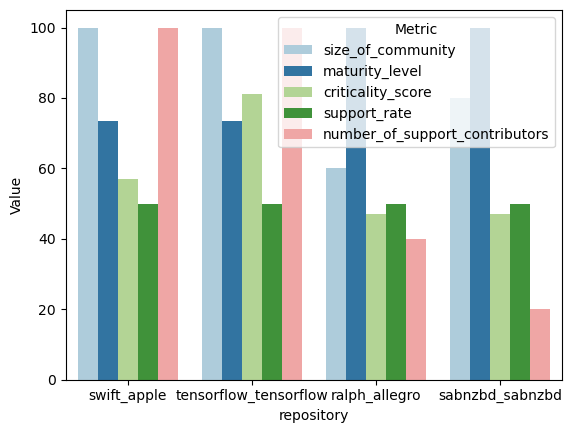

In [ ]:
tmp_df = zhang_df[["repository", "size_of_community", "maturity_level", "criticality_score", "support_rate", "number_of_support_contributors"]]
tmp_df.fillna(0, inplace=True)
tmp_df = tmp_df.melt(id_vars=["repository"], 
        var_name="Metric", 
        value_name="Value")

sns.barplot(data=tmp_df, x="repository", y="Value", hue="Metric", palette=palette)

### Wang et al.

In [ ]:
repo_sample_wang_df = repo_sample_df[repo_sample_df['study'].str.contains("w")]
repo_sample_wang_df

owner              repository    study
55       apple                   swift      z,w
58  tensorflow              tensorflow  z, w, b
68     allegro                   ralph        w
69     sabnzbd                 sabnzbd        w
70         mbi  django-simple-captcha         w

In [ ]:
metrics = {
    "size_of_community": None,
    "maturity_level": None,
    "github_community_health_percentage": ["community_health_score","custom_health_score"]
}
get_metrics(metrics=metrics, study="w", png_filename="wang_health.png")

repository  size_of_community  maturity_level  \
0            swift_apple                100       73.333333   
1  tensorflow_tensorflow                100       73.333333   
2          ralph_allegro                 60      100.000000   
3        sabnzbd_sabnzbd                 80      100.000000   

   community_health_score  custom_health_score  
0                      75                 87.5  
1                      87                 87.5  
2                      50                 75.0  
3                      37                 50.0

In [45]:
metrics = {
    "size_of_community": None,
    "maturity_level": None,
    "github_community_health_percentage": ["community_health_score","custom_health_score"]
}
df = get_metrics(metrics=metrics, study="w")
paper_results = [42.47, 69.56, 16.35, 7.15]
df["Wang_overall_health_score"] = paper_results
df = df.sort_values(by=["Wang_overall_health_score"], ascending=False)
df = df.reset_index(drop=True)
png_filename = "wang_health_score.png"
df.dfi.export(png_filename)

### Foucault et al.

In [84]:

security_advisories_scores = metrics_dict.get("security_advisories")[0]
 # df_chong_advisories.png# df_chong_advisories.png
get_metrics(metrics=metrics, study="f")[["repository", "advisories_available", "patch_ratio", "closed_advisories", "average_cvss_score", "ratio_severity_high_crit"]]

repository  advisories_available  patch_ratio  \
0                rails_rails                  True        100.0   
1          jenkins_jenkinsci                 False          NaN   
2            angular_angular                 False          NaN   
3            ansible_ansible                 False          NaN   
4              jquery_jquery                  True        100.0   
5  phpunit_sebastianbergmann                 False          NaN   
6                  mono_mono                 False          NaN   

   closed_advisories  average_cvss_score  ratio_severity_high_crit  
0                  0                 5.6                 33.333333  
1                  0                 NaN                       NaN  
2                  0                 NaN                       NaN  
3                  0                 NaN                       NaN  
4                  0                 6.1                  0.000000  
5                  0                 NaN                       NaN  
6                  0                 NaN                       NaN

### Tan et al. 

In [157]:
metrics = {
    "branch_lifecycle": ["branch_creation_frequency_days","branch_avg_age_days","stale_ratio","active_ratio","unresolved_ratio","resolved_ratio","branch_state_counter"]
}

get_metrics(metrics=metrics, study="t")

repository  branch_creation_frequency_days  \
0               linux_torvalds                             NaN   
1          WordPress_WordPress                           141.0   
2         Pillow_python-pillow                            92.0   
3                    qemu_qemu                           110.0   
4              openemr_openemr                           145.0   
5                Piwigo_Piwigo                           227.0   
6            glpi_glpi-project                           253.0   
7            jenkins_jenkinsci                            70.0   
8                hhvm_facebook                            18.0   
9            dolibarr_Dolibarr                           161.0   
10               FFmpeg_FFmpeg                           111.0   
11                 zulip_zulip                            95.0   
12      BigTree-CMS_bigtreecms                           226.0   
13           postgres_postgres                           279.0   
14                   ceph_ceph                            23.0   
15            samba_samba-team                           100.0   
16  jackson-databind_FasterXML                           153.0   
17               django_django                           232.0   
18             openssl_openssl                           428.0   
19          clamav_Cisco-Talos                           169.0   
20             xen_xen-project                            91.0   
21       phpmyadmin_phpmyadmin                           217.0   
22               suricata_OISF                           413.0   
23         wireshark_wireshark                            38.0   
24               mongo_mongodb                            42.0   

    branch_avg_age_days  stale_ratio  active_ratio  unresolved_ratio  \
0                   NaN          NaN           NaN               NaN   
1                1568.0    95.555556      4.444444         93.333333   
2                1787.0    97.560976      2.439024         97.560976   
3                2199.0    84.782609     15.217391         91.304348   
4                1538.0    87.500000     12.500000         78.125000   
5                2906.0    86.956522     13.043478         95.652174   
6                2245.0    90.000000     10.000000         95.000000   
7                1209.0    87.500000     12.500000         92.500000   
8                1185.0   100.000000      0.000000         97.487437   
9                1319.0    62.068966     37.931034         96.551724   
10               1703.0    87.878788     12.121212         90.909091   
11                805.0    83.333333     16.666667         91.666667   
12               1307.0    84.615385     15.384615        100.000000   
13               3734.0    82.857143     17.142857         97.142857   
14                581.0    79.393939     20.606061         87.272727   
15               2166.0    85.454545     14.545455        100.000000   
16               1471.0    88.461538     11.538462         80.769231   
17               2401.0    88.000000     12.000000         96.000000   
18               3144.0    85.714286     14.285714         80.952381   
19               1943.0    75.000000     25.000000        100.000000   
20               1375.0    76.744186     23.255814        100.000000   
21               1077.0    90.909091      9.090909         90.909091   
22                872.0    80.000000     20.000000         80.000000   
23               1244.0    99.163180      0.836820         99.163180   
24               1144.0    89.516129     10.483871         71.774194   

    resolved_ratio                               branch_state_counter  
0              NaN                                                 {}  
1         6.666667                       {'Closed': 3, 'Compare': 42}  
2         2.439024                       {'Compare': 40, 'Closed': 1}  
3         8.695652                       {'Compare': 42, 'Closed': 4}  
4        21.875000  {'Compare': 21, 'Closed': 4, 'Merged': 3, 'Ope... 

In [83]:
df = get_metrics(metrics=metrics, study="t")[["repository","branch_creation_frequency_days","branch_avg_age_days","stale_ratio","active_ratio","unresolved_ratio","resolved_ratio","branch_state_counter"]]
df = get_metrics(metrics=metrics, study="t")[["repository", "advisories_available", "patch_ratio", "closed_advisories", "average_cvss_score", "ratio_severity_high_crit"]]
paper_oss_patch_ratio = [22,6,25,24,23, 21,20,19,18, 17, 16,15,14,13,12,11,10,9,8,7 ,5,4 ,3 , 2, 1]

df["Tan_Patch_Ratio_order"] = paper_oss_patch_ratio
df = df.sort_values(by=["Tan_Patch_Ratio_order"], ascending=True)
df = df.reset_index(drop=True)
png_filename = "df_Tan_Patch_Ratio_order.png"
df.dfi.export(png_filename)

In [96]:
# Tan et al. - Branch Patch Ratio/Branche lifecycle
# barplot(df=branch_lifecycle.get("resolved_ratio"), id="resolved_ratio")

### Aman et al.

In [11]:
repo_sample_tan_df = repo_sample_df[repo_sample_df['study'].str.contains("aman")]
repo_sample_tan_df

owner            repository       study
0                angryip                ipscan        aman
1              sabrogden                 Ditto        aman
2             checkstyle            eclipse-cs        aman
3            FirebirdSQL              firebird        aman
4                    git                   git        aman
5                  GNOME               gparted        aman
6              hibernate         hibernate-orm        aman
7           hpcc-systems         HPCC-Platform        aman
8                    KDE                kdiff3        aman
9          libjpeg-turbo         libjpeg-turbo        aman
10              torvalds                 linux   aman,t, b
11           MediaPortal         MediaPortal-1        aman
12         mediathekview         MediathekView        aman
13        moneymanagerex        moneymanagerex        aman
14                moodle                moodle        aman
15     NagiosEnterprises            nagioscore        aman
16              cyanfish                 naps2        aman
17              net-snmp              net-snmp        aman
18           bruderstein          PythonScript        aman
19            pandorafms            pandorafms        aman
20                pwsafe                pwsafe        aman
21                   pmd                   pmd        aman
22                  ruby                  ruby        aman
23                 rails                 rails     aman, f
24        scribusproject               scribus        aman
25            nigels-com                  glew        aman
26            unetbootin            unetbootin        aman
27  UniversalMediaServer  UniversalMediaServer        aman
28           wine-mirror                  wine        aman
29             WordPress             WordPress  aman, t, b
30                 xcat2             xcat-core        aman

### Bhandari et al.

In [72]:

 # df_chong_advisories.png
df = get_metrics(metrics=metrics, study="b")[["repository", "advisories_available", "patch_ratio", "closed_advisories", "average_cvss_score", "ratio_severity_high_crit"]]
df
paper_cves_found = [973, 46, 40, 83, 67, 143, 157, 89, 60, 50]
paper_average_cvss3 = [3.99, 7.01, 7.54, 5.86, 3.55, 6.67, 7.25, 9.57, 7.46, 6.70]

df["Bhandari_CVEs_found"] = paper_cves_found
df["Bhandari_avg_CVSS_v3"] = paper_average_cvss3
df = df.sort_values(by=["Bhandari_CVEs_found"], ascending=False)
df = df.reset_index(drop=True)
png_filename = "df_Bhandari_vulnerabilities.png"
df.dfi.export(png_filename)

### Chong et al.

In [25]:
 # df_chong_advisories.png
get_metrics(metrics=metrics, study="cho")[["repository", "advisories_available", "patch_ratio", "closed_advisories", "average_cvss_score", "ratio_severity_high_crit"]]

code_dependency
1968850
AttributeError: 'NoneType' object has no attribute 'get'
code_dependency
312430210
AttributeError: 'NoneType' object has no attribute 'get'
code_dependency
116061796
AttributeError: 'NoneType' object has no attribute 'get'
code_dependency
54005538
AttributeError: 'NoneType' object has no attribute 'get'
code_dependency
36502
AttributeError: 'NoneType' object has no attribute 'get'
code_dependency
4598769
AttributeError: 'NoneType' object has no attribute 'get'
code_dependency
961036
AttributeError: 'NoneType' object has no attribute 'get'
code_dependency
2030681
AttributeError: 'NoneType' object has no attribute 'get'
code_dependency
121531680
AttributeError: 'NoneType' object has no attribute 'get'
code_dependency
39760454
AttributeError: 'NoneType' object has no attribute 'get'
code_dependency
2325298
AttributeError: 'NoneType' object has no attribute 'get'
code_dependency
2546562
AttributeError: 'NoneType' object has no attribute 'get'
code_dependency
2301899

repository  advisories_available  patch_ratio  closed_advisories  \
0        django_django                 False          NaN                  0   
1  keystone_keystonejs                  True    83.333333                  0   
2           cxf_apache                 False          NaN                  0   
3        tomcat_apache                 False          NaN                  0   

   average_cvss_score  ratio_severity_high_crit  
0                 NaN                       NaN  
1                6.88                      50.0  
2                 NaN                       NaN  
3                 NaN                       NaN

In [62]:
 # df_chong_advisories.png
df = get_metrics(metrics=metrics, study="cho")[["repository", "advisories_available", "patch_ratio", "closed_advisories", "average_cvss_score", "ratio_severity_high_crit"]]
paper_results = [78, 120, 45, None]
df["Chong_vulnerabilities"] = paper_results
df = df.sort_values(by=["Chong_vulnerabilities"], ascending=False)
df = df.reset_index(drop=True)
png_filename = "Chong_vulnerabilities.png"
df.dfi.export(png_filename)

### Chan et al.

In [55]:
 # df_chong_advisories.png# df_chong_advisories.png
get_metrics(metrics=metrics, study="cha")[["repository", "advisories_available", "patch_ratio", "closed_advisories", "average_cvss_score", "ratio_severity_high_crit"]]

code_dependency
1968850
AttributeError: 'NoneType' object has no attribute 'get'
code_dependency
312430210
AttributeError: 'NoneType' object has no attribute 'get'
code_dependency
116061796
AttributeError: 'NoneType' object has no attribute 'get'
code_dependency
54005538
AttributeError: 'NoneType' object has no attribute 'get'
code_dependency
36502
AttributeError: 'NoneType' object has no attribute 'get'
code_dependency
4598769
AttributeError: 'NoneType' object has no attribute 'get'
code_dependency
961036
AttributeError: 'NoneType' object has no attribute 'get'
code_dependency
2030681
AttributeError: 'NoneType' object has no attribute 'get'
code_dependency
121531680
AttributeError: 'NoneType' object has no attribute 'get'
code_dependency
39760454
AttributeError: 'NoneType' object has no attribute 'get'
code_dependency
2325298
AttributeError: 'NoneType' object has no attribute 'get'
code_dependency
2546562
AttributeError: 'NoneType' object has no attribute 'get'
code_dependency
2301899

repository  advisories_available  patch_ratio  \
0               openssl_openssl                 False          NaN   
1                     curl_curl                 False          NaN   
2         libarchive_libarchive                 False          NaN   
3           mongoose_Automattic                 False          NaN   
4           sleuthkit_sleuthkit                 False          NaN   
5               libgit2_libgit2                  True        100.0   
6                   aubio_aubio                 False          NaN   
7             libevent_libevent                 False          NaN   
8               libvips_libvips                 False          NaN   
9              poco_pocoproject                 False          NaN   
10                   npcap_nmap                 False          NaN   
11                libusb_libusb                 False          NaN   
12  inotify-tools_inotify-tools                 False          NaN   

    closed_advisories  average_cvss_score  ratio_severity_high_crit  
0                   0                 NaN                       NaN  
1                   0                 NaN                       NaN  
2                   0                 NaN                       NaN  
3                   0                 NaN                       NaN  
4                   0                 NaN                       NaN  
5                   0                 5.3                       0.0  
6                   0                 NaN                       NaN  
7                   0                 NaN                       NaN  
8                   0                 NaN                       NaN  
9                   0                 NaN                       NaN  
10                  0                 NaN                       NaN  
11                  0                 NaN                       NaN  
12                  0                 NaN                       NaN

In [69]:
 # df_chong_advisories.png
df = get_metrics(metrics=metrics, study="cha")[["repository", "advisories_available", "patch_ratio", "closed_advisories", "average_cvss_score", "ratio_severity_high_crit"]]
paper_results_cve = [233, 66, 57, 22, 15, 13, 9, 6, 3, 2, 1, 1, 1]
paper_results_cve_fixed = [160, 25, 38, 3, 1, 13, 0, 2, 3, 2, 0, 0, 1]
df["Chan_CVEs_found"] = paper_results_cve
df["Chan_CVEs_found_and_fixed"] = paper_results_cve_fixed
df = df.sort_values(by=["Chan_CVEs_found"], ascending=False)
df = df.reset_index(drop=True)
png_filename = "df_Chan_vulnerabilities.png"
df.dfi.export(png_filename)

## Large Sample

In [360]:
metrics = {
    "maturity_level": None,
    "osi_approved_license": None,
    "criticality_score":None,
    "technical_fork": ["total_forks", "forks_contributed", "forks_not_contributed", "forks_contributed_ratio", "forks_not_contributed_ratio", "average_forks_created_per_week"],
    "pull_requests": ["total_pulls", "avg_pull_closing_days", "ratio_open_total", "ratio_closed_total", "ratio_merged_total"],
    "project_velocity": ["total_issues", "closed_issues", "open_issues", "pull_count", "no_pull_count", "ratio_pull_issue", "avg_issue_resolving_days", "ratio_open_total", "ratio_closed_total"],
    "github_community_health_percentage": ["community_health_score","custom_health_score", "true_count", "false_count", "description", "documentation", "code_of_conduct",
                                          "contributing", "issue_template", "pull_request_template", "license", "readme"],
    "issues": ["total_issues", "open_issues", "closed_issues", "new_issues", "new_ratio", "average_issues_created_per_week", "average_issue_comments", "average_issue_resolving_days",
              "average_first_response_time_days", "ratio_open_total", "ratio_closed_total"],
    "support_rate": None,
    "code_dependency": ["total_upstream", "total_downstream", "visible_downstream"],
    "security_advisories": ["advisories_available", "patch_ratio", "closed_advisories", "average_cvss_score", "ratio_severity_high_crit"],
    "contributions_distributions": ["bus_factor_score", "RoC_twenty_percent", "RoC_eighty_percent_soll", "RoC_eighty_percent_ist", "RoC_diff_pareto_soll_ist_percent", "avg_num_contributors_per_file",
                                    "NoC_twenty_percent", "NoC_eighty_percent_soll", "NoC_eighty_percent_ist", "NoC_diff_pareto_soll_ist_percent"],
    "number_of_support_contributors": None,
    "elephant_factor": None,
    "size_of_community": None,
    "churn": None,
    "branch_lifecycle": ["branch_creation_frequency_days", "branch_avg_age_days", "stale_ratio", "active_ratio", "unresolved_ratio", "resolved_ratio", "branch_state_counter"]
}

In [361]:
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)


In [368]:

path_metrics = os.path.join(parent_dir,"outputs", "results")
path_repository = os.path.join(parent_dir,"outputs", "data")
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

languages = ["php", "cpp", "python", "JavaScript", "java"]
large_sample_metrics = pd.DataFrame()
for lang in languages:
    path_repo = os.path.join(path_repository, lang + "_repository.json")
    print(path_repo)
    repository_dict = json_to_dict(path=path_repo)
    print(len(repository_dict))
    for file in os.listdir(path_metrics):
        if file.endswith(".json") and file.startswith(lang):
            file_path = os.path.join(path_metrics, file)
            metrics_dict = json_to_dict(path=file_path)
            metrics_results = get_metrics(metrics=metrics, metrics_dict=metrics_dict,repository_dict=repository_dict)
            metrics_results["language"] = lang
            if len(large_sample_metrics.columns) == 0:
                large_sample_metrics = metrics_results
            else:
                large_sample_metrics = pd.concat([large_sample_metrics, metrics_results], ignore_index=True)

            


c:\Users\Jacky\OneDrive - Fachhochschule St. Pölten\Diplomarbeit\Diplomarbeit\MDI_Thesis\outputs\data\php_repository.json
1000
maturity_level
osi_approved_license
criticality_score
technical_fork
pull_requests
project_velocity
github_community_health_percentage
issues
support_rate
code_dependency
security_advisories
contributions_distributions
number_of_support_contributors
elephant_factor
size_of_community
churn
branch_lifecycle
c:\Users\Jacky\OneDrive - Fachhochschule St. Pölten\Diplomarbeit\Diplomarbeit\MDI_Thesis\outputs\data\cpp_repository.json
1000
maturity_level
osi_approved_license
criticality_score
technical_fork
pull_requests
project_velocity
github_community_health_percentage
issues
support_rate
code_dependency
security_advisories
contributions_distributions
number_of_support_contributors
elephant_factor
size_of_community
churn
branch_lifecycle
c:\Users\Jacky\OneDrive - Fachhochschule St. Pölten\Diplomarbeit\Diplomarbeit\MDI_Thesis\outputs\data\python_repository.json
1000
ma

In [ ]:
total_small_sample [["repository", "total_upstream", "total_downstream", "visible_downstream"]]

repository  total_upstream  \
0                              ipscan_angryip            50.0   
1                             Ditto_sabrogden            50.0   
2                       eclipse-cs_checkstyle            50.0   
3                        firebird_FirebirdSQL            50.0   
4                                     git_git            50.0   
5                               gparted_GNOME            50.0   
6                     hibernate-orm_hibernate            50.0   
7                  HPCC-Platform_hpcc-systems            50.0   
8                                  kdiff3_KDE            50.0   
9                 libjpeg-turbo_libjpeg-turbo            50.0   
10                             linux_torvalds            50.0   
11                  MediaPortal-1_MediaPortal            50.0   
12                MediathekView_mediathekview            50.0   
13              moneymanagerex_moneymanagerex            50.0   
14                              moodle_moodle            50.0   
15               nagioscore_NagiosEnterprises            50.0   
16                             naps2_cyanfish            50.0   
17                          net-snmp_net-snmp            50.0   
18                   PythonScript_bruderstein            50.0   
19                      pandorafms_pandorafms            50.0   
20                              pwsafe_pwsafe            50.0   
21                                    pmd_pmd            50.0   
22                                  ruby_ruby            50.0   
23                                rails_rails            50.0   
24                     scribus_scribusproject            50.0   
25                            glew_nigels-com            50.0   
26                      unetbootin_unetbootin            50.0   
27  UniversalMediaServer_UniversalMediaServer            50.0   
28                           wine_wine-mirror            50.0   
29                        WordPress_WordPress            50.0   
30                            xcat-core_xcat2            50.0   
31                       Pillow_python-pillow            50.0   
32                                  qemu_qemu            50.0   
33                            openemr_openemr            50.0   
34                              Piwigo_Piwigo            50.0   
35                          glpi_glpi-project            50.0   
36                          jenkins_jenkinsci            50.0   
37                              hhvm_facebook            50.0   
38                          dolibarr_Dolibarr            50.0   
39                              FFmpeg_FFmpeg            50.0   
40                                zulip_zulip            50.0   
41                     BigTree-CMS_bigtreecms            50.0   
42                          postgres_postgres            50.0   
43                                  ceph_ceph            50.0   
44                           samba_samba-team            50.0   
45                 jackson-databind_FasterXML            50.0   
46                              django_django            50.0   
47                            openssl_openssl            50.0   
48                         clamav_Cisco-Talos            50.0   
49                            xen_xen-project            50.0   
50                      phpmyadmin_phpmyadmin            50.0   
51                              suricata_OISF            50.0   
52                        wireshark_wireshark            50.0   
53                              mongo_mongodb            50.0   
54                       TypeScript_microsoft            50.0   
55                                swift_apple            50.0   
56                           vscode_microsoft            50.0   
57                            grafana_grafana            50.0   
58                      tensorflow_tensorflow            50.0   
59                                  vue_vuejs            50.0   
60                        keystone_keystonejs            50.0   
61   

In [ ]:
total_small_sample [["repository", "open_issues", "closed_issues", "new_issues", "new_ratio", "average_issues_created_per_week", "average_issue_comments", "average_issue_resolving_days",
              "average_first_response_time_days", "ratio_open_total", "ratio_closed_total"]]

repository  open_issues  closed_issues  \
0                              ipscan_angryip            0              0   
1                             Ditto_sabrogden            0              0   
2                       eclipse-cs_checkstyle            0              0   
3                        firebird_FirebirdSQL            0              0   
4                                     git_git            0              0   
5                               gparted_GNOME            0              0   
6                     hibernate-orm_hibernate            0              0   
7                  HPCC-Platform_hpcc-systems            0              0   
8                                  kdiff3_KDE            0              0   
9                 libjpeg-turbo_libjpeg-turbo            0              0   
10                             linux_torvalds            0              0   
11                  MediaPortal-1_MediaPortal            0              0   
12                MediathekView_mediathekview            0              0   
13              moneymanagerex_moneymanagerex            0              0   
14                              moodle_moodle            0              0   
15               nagioscore_NagiosEnterprises            0              0   
16                             naps2_cyanfish            0              0   
17                          net-snmp_net-snmp            0              0   
18                   PythonScript_bruderstein            0              0   
19                      pandorafms_pandorafms            0              0   
20                              pwsafe_pwsafe            0              0   
21                                    pmd_pmd            0              0   
22                                  ruby_ruby            0              0   
23                                rails_rails            0              0   
24                     scribus_scribusproject            0              0   
25                            glew_nigels-com            0              0   
26                      unetbootin_unetbootin            0              0   
27  UniversalMediaServer_UniversalMediaServer            0              0   
28                           wine_wine-mirror            0              0   
29                        WordPress_WordPress            0              0   
30                            xcat-core_xcat2            0              0   
31                       Pillow_python-pillow            0              0   
32                                  qemu_qemu            0              0   
33                            openemr_openemr            0              0   
34                              Piwigo_Piwigo            0              0   
35                          glpi_glpi-project            0              0   
36                          jenkins_jenkinsci            0              0   
37                              hhvm_facebook            0              0   
38                          dolibarr_Dolibarr            0              0   
39                              FFmpeg_FFmpeg            0              0   
40                                zulip_zulip            0              0   
41                     BigTree-CMS_bigtreecms            0              0   
42                          postgres_postgres            0              0   
43                                  ceph_ceph            0              0   
44                           samba_samba-team            0              0   
45                 jackson-databind_FasterXML            0              0   
46                              django_django            0              0   
47                            openssl_openssl            0              0   
48                         clamav_Cisco-Talos            0              0   
49                            xen_xen-project            0              0   
50                      phpmyadmin_phpmyadmin            0              0   
51                             

In [ ]:
total_small_sample [["repository", "total_issues", "closed_issues", "open_issues", "pull_count", "no_pull_count", "ratio_pull_issue", "avg_issue_resolving_days", "ratio_open_total", "ratio_closed_total"]]

total_issues  closed_issues  open_issues  pull_count  no_pull_count  \
0              0              0            0           0              0   
1              0              0            0           0              2   
2              0              0            0           0              1   
3              0              0            0           2              7   
4              0              0            0           4              0   
5              0              0            0           0              0   
6              0              0            0           8              0   
7              0              0            0          15              0   
8              0              0            0           0              0   
9              0              0            0           0              0   
10             0              0            0           1              0   
11             0              0            0           0              0   
12             0              0            0           0              0   
13             0              0            0           0              1   
14             0              0            0           0              0   
15             0              0            0           0              0   
16             0              0            0           0              2   
17             0              0            0           2              1   
18             0              0            0           0              0   
19             0              0            0           0              0   
20             0              0            0           1              1   
21             0              0            0           0              1   
22             0              0            0          24              0   
23             0              0            0          17              3   
24             0              0            0           0              0   
25             0              0            0           0              0   
26             0              0            0           0              0   
27             0              0            0          12              4   
28             0              0            0           0              0   
29             0              0            0           0              0   
30             0              0            0           0              2   
31             0              0            0           3              2   
32             0              0            0           0              0   
33             0              0            0           9              4   
34             0              0            0           0              4   
35             0              0            0          43              8   
36             0              0            0          16              0   
37             0              0            0           1              0   
38             0              0            0          19              7   
39             0              0            0           0              0   
40             0              0            0          18              6   
41             0              0            0           1              2   
42             0              0            0           0              0   
43             0              0            0          36              0   
44             0              0            0           0              0   
45             0              0            0           4              1   
46             0              0            0          12              0   
47             0              0            0          19             10   
48             0              0            0           7              0   
49             0              0            0           0              0   
50             0              0            0           2              1   
51             0              0            0           3              0   
52             0             

In [ ]:
total_small_sample [["repository", "total_pulls", "avg_pull_closing_days", "ratio_open_total", "ratio_closed_total", "ratio_merged_total"]]

total_pulls  avg_pull_closing_days ratio_open_total ratio_closed_total  \
0             0                    NaN             None               None   
1             0                    NaN             None               None   
2             0                    NaN             None               None   
3             2               5.000000             None               None   
4             4                    NaN             None               None   
5             0                    NaN             None               None   
6             8                    NaN             None               None   
7            15               3.285714             None               None   
8             0                    NaN             None               None   
9             0                    NaN             None               None   
10            0                    NaN             None               None   
11            0                    NaN             None               None   
12            0                    NaN             None               None   
13            0                    NaN             None               None   
14            0                    NaN             None               None   
15            0                    NaN             None               None   
16            0                    NaN             None               None   
17            2               0.000000             None               None   
18            0                    NaN             None               None   
19            0                    NaN             None               None   
20            1               0.000000             None               None   
21            0                    NaN             None               None   
22           24               3.352941             None               None   
23           17               0.777778             None               None   
24            0                    NaN             None               None   
25            0                    NaN             None               None   
26            0                    NaN             None               None   
27           11               3.714286             None               None   
28            0                    NaN             None               None   
29            0                    NaN             None               None   
30            0                    NaN             None               None   
31            3              13.000000             None               None   
32            0                    NaN             None               None   
33            9               2.000000             None               None   
34            0                    NaN             None               None   
35           47              13.250000             None               None   
36           16               0.250000             None               None   
37            1                    NaN             None               None   
38           19               0.555556             None               None   
39            0                    NaN             None               None   
40           20               2.000000             None               None   
41            1                    NaN             None               None   
42            0                    NaN             None               None   
43           36               0.200000             None               None   
44            0                    NaN             None               None   
45            4              23.000000             None               None   
46           11               0.500000             None               None   
47           19                    NaN             None               None   
48            7               4.500000             None               None   
49            0                    NaN             None               None   
50            2           

In [ ]:
total_small_sample [["repository","total_forks", "forks_contributed", "forks_not_contributed", "forks_contributed_ratio", "forks_not_contributed_ratio", "average_forks_created_per_week"]]

repository  total_forks  forks_contributed  \
0                              ipscan_angryip            0                  0   
1                             Ditto_sabrogden            0                  0   
2                       eclipse-cs_checkstyle            0                  0   
3                        firebird_FirebirdSQL            0                  0   
4                                     git_git            1                  0   
5                               gparted_GNOME            0                  0   
6                     hibernate-orm_hibernate            0                  0   
7                  HPCC-Platform_hpcc-systems            0                  0   
8                                  kdiff3_KDE            0                  0   
9                 libjpeg-turbo_libjpeg-turbo            0                  0   
10                             linux_torvalds            1                  0   
11                  MediaPortal-1_MediaPortal            0                  0   
12                MediathekView_mediathekview            0                  0   
13              moneymanagerex_moneymanagerex            0                  0   
14                              moodle_moodle            0                  0   
15               nagioscore_NagiosEnterprises            0                  0   
16                             naps2_cyanfish            0                  0   
17                          net-snmp_net-snmp            0                  0   
18                   PythonScript_bruderstein            0                  0   
19                      pandorafms_pandorafms            0                  0   
20                              pwsafe_pwsafe            0                  0   
21                                    pmd_pmd            0                  0   
22                                  ruby_ruby            0                  0   
23                                rails_rails            0                  0   
24                     scribus_scribusproject            0                  0   
25                            glew_nigels-com            0                  0   
26                      unetbootin_unetbootin            0                  0   
27  UniversalMediaServer_UniversalMediaServer            0                  0   
28                           wine_wine-mirror            0                  0   
29                        WordPress_WordPress            1                  0   
30                            xcat-core_xcat2            0                  0   
31                       Pillow_python-pillow            0                  0   
32                                  qemu_qemu            0                  0   
33                            openemr_openemr            1                  0   
34                              Piwigo_Piwigo            0                  0   
35                          glpi_glpi-project            0                  0   
36                          jenkins_jenkinsci            0                  0   
37                              hhvm_facebook            0                  0   
38                          dolibarr_Dolibarr            0                  0   
39                              FFmpeg_FFmpeg            0                  0   
40                                zulip_zulip            0                  0   
41                     BigTree-CMS_bigtreecms            0                  0   
42                          postgres_postgres            0                  0   
43                                  ceph_ceph            0                  0   
44                           samba_samba-team            0                  0   
45                 jackson-databind_FasterXML            0                  0   
46                              django_django            0                  0   
47                            openssl_openssl            0                  0   
48                         clamav_Cisco-Talos            0        

In [ ]:
total_small_sample [["repository","maturity_level", "support_rate", "number_of_support_contributors", "size_of_community", "criticality_score"]]

repository  maturity_level  support_rate  \
0                              ipscan_angryip      100.000000          50.0   
1                             Ditto_sabrogden       93.333333          50.0   
2                       eclipse-cs_checkstyle      100.000000          50.0   
3                        firebird_FirebirdSQL      100.000000          50.0   
4                                     git_git       73.333333          50.0   
5                               gparted_GNOME       73.333333           NaN   
6                     hibernate-orm_hibernate      100.000000          50.0   
7                  HPCC-Platform_hpcc-systems      100.000000          50.0   
8                                  kdiff3_KDE       73.333333           NaN   
9                 libjpeg-turbo_libjpeg-turbo      100.000000          50.0   
10                             linux_torvalds       73.333333           0.0   
11                  MediaPortal-1_MediaPortal      100.000000          50.0   
12                MediathekView_mediathekview       73.333333          50.0   
13              moneymanagerex_moneymanagerex      100.000000          50.0   
14                              moodle_moodle       73.333333          50.0   
15               nagioscore_NagiosEnterprises      100.000000          50.0   
16                             naps2_cyanfish      100.000000          50.0   
17                          net-snmp_net-snmp       73.333333          50.0   
18                   PythonScript_bruderstein      100.000000          50.0   
19                      pandorafms_pandorafms       73.333333          50.0   
20                              pwsafe_pwsafe      100.000000          50.0   
21                                    pmd_pmd      100.000000          50.0   
22                                  ruby_ruby      100.000000          50.0   
23                                rails_rails      100.000000          50.0   
24                     scribus_scribusproject       73.333333          50.0   
25                            glew_nigels-com       86.666667          50.0   
26                      unetbootin_unetbootin      100.000000          50.0   
27  UniversalMediaServer_UniversalMediaServer      100.000000          50.0   
28                           wine_wine-mirror       73.333333          50.0   
29                        WordPress_WordPress       73.333333          50.0   
30                            xcat-core_xcat2      100.000000          50.0   
31                       Pillow_python-pillow      100.000000          50.0   
32                                  qemu_qemu       73.333333          50.0   
33                            openemr_openemr       73.333333          50.0   
34                              Piwigo_Piwigo      100.000000          50.0   
35                          glpi_glpi-project      100.000000          50.0   
36                          jenkins_jenkinsci      100.000000          50.0   
37                              hhvm_facebook      100.000000          50.0   
38                          dolibarr_Dolibarr      100.000000          50.0   
39                              FFmpeg_FFmpeg       73.333333          50.0   
40                                zulip_zulip      100.000000          50.0   
41                     BigTree-CMS_bigtreecms       73.333333          50.0   
42                          postgres_postgres       73.333333          50.0   
43                                  ceph_ceph       73.333333          50.0   
44                           samba_samba-team       73.333333          50.0   
45                 jackson-databind_FasterXML       73.333333          50.0   
46                              django_django       73.333333          50.0   
47                            openssl_openssl      100.000000          50.0   
48                         clamav_Cisco-Talos      100.000000          50.0   
49                            xen_xen-project       73.333333          50.0   
50    

### OSI approved license

In [369]:
osi_large = large_sample_metrics[["language", "osi_approved_license"]].value_counts()#.to_frame()
osi_large.to_frame()

count
language   osi_approved_license       
python     not_found               942
JavaScript not_found               933
cpp        not_found               932
php        not_found               926
java       not_found               905
           not_provided             95
php        not_provided             74
cpp        not_provided             68
JavaScript not_provided             67
python     not_provided             58

<Axes: xlabel='osi_approved_license', ylabel='count'>

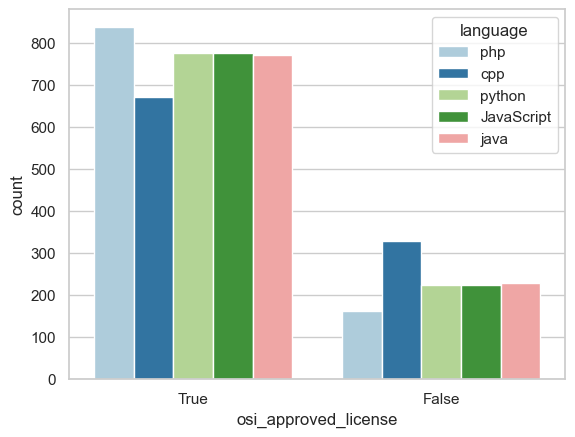

In [365]:
osi = tmp_df.value_counts()
sns.countplot(data=tmp_df, x="osi_approved_license", order=tmp_df.osi_approved_license.value_counts().index, hue=tmp_df.language, palette=palette)
# df_plot = osi_large.groupby(['osi_approved_license']).size().reset_index().pivot(columns = 'osi_approved_license',index='language', values=0)
# df_plot.plot(kind='bar', stacked=True, hue=tmp_df.language, palette=palette)
# tmp_df.set_index('osi_approved_license'.value_counts()).plot(kind='bar', stacked=True, color=['steelblue', 'red'])
# plt.savefig("plot_osi_approved_license.png")

### Churn

In [336]:
churn_large = large_sample_metrics [["language", "churn"]]
churn_large_sample_summary = churn_large.groupby("language").describe().transpose()
png_filename = "large_sample_churn_metrics.png"
churn_large_sample_summary.dfi.export(png_filename)
churn_large_sample_summary

language     JavaScript    cpp java    php python
churn count           0  623.0    0  474.0  574.0
      unique          0  574.0    0  370.0  503.0
      top           NaN  100.0  NaN  100.0  100.0
      freq          NaN   26.0  NaN   53.0   46.0

### Branches

In [333]:
branches_large = large_sample_metrics[["language","repository", "branch_state_counter", "branch_creation_frequency_days", "branch_avg_age_days", "stale_ratio", "active_ratio", "unresolved_ratio", "resolved_ratio"]]


branches_large_sample_summary = branches_large.groupby("language").describe()

branches_large_sample_summary = branches_large_sample_summary.reset_index().transpose()
# branches_large_sample_summary = branches_large_sample_summary.rename(columns=branches_large_sample_summary.iloc[0]).drop(advisories_large_sample_summary.index[0])
png_filename = "large_sample_branches_summary.png"
branches_large_sample_summary.dfi.export(png_filename)
# branches_large_sample_summary.transpose().xs("count", level=1, axis=1)["patch_ratio"]

### Contributions Distributions

In [ ]:
total_small_sample [["repository", "bus_factor_score", "elephant_factor", "RoC_twenty_percent", "RoC_eighty_percent_soll", "RoC_eighty_percent_ist", "RoC_diff_pareto_soll_ist_percent", "avg_num_contributors_per_file",
                                    "NoC_twenty_percent", "NoC_eighty_percent_soll", "NoC_eighty_percent_ist", "NoC_diff_pareto_soll_ist_percent"]]

repository  bus_factor_score  \
0                              ipscan_angryip               NaN   
1                             Ditto_sabrogden               NaN   
2                       eclipse-cs_checkstyle               1.0   
3                        firebird_FirebirdSQL               4.0   
4                                     git_git               4.0   
5                               gparted_GNOME               1.0   
6                     hibernate-orm_hibernate               2.0   
7                  HPCC-Platform_hpcc-systems               2.0   
8                                  kdiff3_KDE               1.0   
9                 libjpeg-turbo_libjpeg-turbo               1.0   
10                             linux_torvalds             172.0   
11                  MediaPortal-1_MediaPortal               1.0   
12                MediathekView_mediathekview               1.0   
13              moneymanagerex_moneymanagerex               1.0   
14                              moodle_moodle               5.0   
15               nagioscore_NagiosEnterprises               1.0   
16                             naps2_cyanfish               1.0   
17                          net-snmp_net-snmp               1.0   
18                   PythonScript_bruderstein               2.0   
19                      pandorafms_pandorafms               7.0   
20                              pwsafe_pwsafe               1.0   
21                                    pmd_pmd               2.0   
22                                  ruby_ruby               5.0   
23                                rails_rails               6.0   
24                     scribus_scribusproject               1.0   
25                            glew_nigels-com               1.0   
26                      unetbootin_unetbootin               1.0   
27  UniversalMediaServer_UniversalMediaServer               1.0   
28                           wine_wine-mirror               7.0   
29                        WordPress_WordPress               2.0   
30                            xcat-core_xcat2               2.0   
31                       Pillow_python-pillow               2.0   
32                                  qemu_qemu              13.0   
33                            openemr_openemr               3.0   
34                              Piwigo_Piwigo               1.0   
35                          glpi_glpi-project               3.0   
36                          jenkins_jenkinsci               3.0   
37                              hhvm_facebook               7.0   
38                          dolibarr_Dolibarr               1.0   
39                              FFmpeg_FFmpeg               4.0   
40                                zulip_zulip               6.0   
41                     BigTree-CMS_bigtreecms               1.0   
42                          postgres_postgres               4.0   
43                                  ceph_ceph              16.0   
44                           samba_samba-team               3.0   
45                 jackson-databind_FasterXML               1.0   
46                              django_django               9.0   
47                            openssl_openssl               4.0   
48                         clamav_Cisco-Talos               1.0   
49                            xen_xen-project               6.0   
50                      phpmyadmin_phpmyadmin               2.0   
51                              suricata_OISF               2.0   
52                        wireshark_wireshark               5.0   
53                              mongo_mongodb              46.0   
54                       TypeScript_microsoft               4.0   
55                                swift_apple              12.0   
56                           vscode_microsoft               8.0   
57                            grafana_grafana              32.0   
58                      tensorflow_tensorflow              20.0   
59             

### Security Advisories

In [ ]:
advisories_large_sample = large_sample_metrics [["language", "advisories_available", "patch_ratio", "closed_advisories", "average_cvss_score", "ratio_severity_high_crit"]]

advisories_large_sample_summary = advisories_large_sample.groupby("language").describe()

advisories_large_sample_summary = advisories_large_sample_summary#.transpose()
advisories_large_sample_summary = advisories_large_sample_summary.reset_index().transpose()
advisories_large_sample_summary = advisories_large_sample_summary.rename(columns=advisories_large_sample_summary.iloc[0]).drop(advisories_large_sample_summary.index[0])
png_filename = "large_sample_advisories_summary.png"
advisories_large_sample_summary.dfi.export(png_filename)
advisories_large_sample_summary.transpose().xs("count", level=1, axis=1)["patch_ratio"]

### Code Dependency

In [352]:
large_sample_metrics[["language", "repository", "total_upstream", "total_downstream", "visible_downstream"]]

language  \
0            php   
1            php   
2            php   
3            php   
4            php   
5            php   
6            php   
7            php   
8            php   
9            php   
10           php   
11           php   
12           php   
13           php   
14           php   
15           php   
16           php   
17           php   
18           php   
19           php   
20           php   
21           php   
22           php   
23           php   
24           php   
25           php   
26           php   
27           php   
28           php   
29           php   
30           php   
31           php   
32           php   
33           php   
34           php   
35           php   
36           php   
37           php   
38           php   
39           php   
40           php   
41           php   
42           php   
43           php   
44           php   
45           php   
46           php   
47           php   
48           php   
49           php   
50           php   
51           php   
52           php   
53           php   
54           php   
55           php   
56           php   
57           php   
58           php   
59           php   
60           php   
61           php   
62           php   
63           php   
64           php   
65           php   
66           php   
67           php   
68           php   
69           php   
70           php   
71           php   
72           php   
73           php   
74           php   
75           php   
76           php   
77           php   
78           php   
79           php   
80           php   
81           php   
82           php   
83           php   
84           php   
85           php   
86           php   
87           php   
88           php   
89           php   
90           php   
91           php   
92           php   
93           php   
94           php   
95           php   
96           php   
97           php   
98           php   
99           php   
100          php   
101          php   
102          php   
103          php   
104          php   
105          php   
106          php   
107          php   
108          php   
109          php   
110          php   
111          php   
112          php   
113          php   
114          php   
115          php   
116          php   
117          php   
118          php   
119          php   
120          php   
121          php   
122          php   
123          php   
124          php   
125          php   
126          php   
127          php   
128          php   
129          php   
130          php   
131          php   
132          php   
133          php   
134          php   
135          php   
136          php   
137          php   
138          php   
139          php   
140          php   
141          php   
142          php   
143          php   
144          php   
145          php   
146          php   
147          php   
148          php   
149          php   
150          php   
151          php   
152          php   
153          php   
154          php   
155          php   
156          php   
157          php   
158          php   
159          php   
160          php   
161          php   
162          php   
163          php   
164          php   
165          php   
166          php   
167          php   
168          php   
169          php   
170          php   
171          php   
172          php   
173          php   
174          php   
175          php   
176          php   
177          php   
178          php   
179          php   
180          php   
181          php   
182          php   
183          php   
184          php   
185          php   
186          php   
187          php   
188          php   
189          php   
190          php   
191          php   
192          php   
193          php   
194          php   
195          php   
196          php   
197          php   
198          php   
199     

### Community Health Score

In [329]:
health_large_sample = large_sample_metrics [["language", "community_health_score","custom_health_score", "true_count", "false_count", "description", "documentation", "code_of_conduct",
                                          "contributing", "issue_template", "pull_request_template", "license", "readme"]]
# png_filename = "small_sample_health_metrics.png"
# health_small_sample.dfi.export(png_filename)
# health_small_sample_head = health_small_sample.head(20)
# png_filename = "small_sample_health_metrics_top20.png"
# health_small_sample_head.dfi.export(png_filename)

health_large_summary = health_large_sample[["language", "community_health_score","custom_health_score"]].describe()
health_large_summary = health_large_summary.transpose()
health_large_summary.dfi.export("large_sample_health_description.png")

In [ ]:
repo_small = total_small_sample [["repository", "osi_approved_license"]]
png_filename = "small_sample_repository_metrics.png"
# repo_small.dfi.export(png_filename)
repo_small_head = repo_small.head(20)
png_filename = "small_sample_repository_metrics_top20.png"
repo_small_summary = repo_small['osi_approved_license'].describe()
repo_small_summary = repo_small_summary
# repo_small_head.dfi.export(png_filename)
repo_small_summary.to_frame().transpose()

count unique   top freq
osi_approved_license    86      2  True   47

In [ ]:
churn_small = total_small_sample [["repository", "churn"]]
png_filename = "small_sample_churn_metrics.png"
# churn_small.dfi.export(png_filename)
churn_small_head = churn_small.head(20)
png_filename = "small_sample_churn_metrics_top20.png"
# churn_small_head.dfi.export(png_filename)
churn_summary = churn_small['churn'].describe()
churn_summary = churn_summary
churn_summary = churn_summary.to_frame().transpose()
churn_summary.dfi.export("small_sample_churn_description.png")
# print(churn_summary) #.to_csv("small_sample_churn_description.csv")

In [ ]:
branches_small = total_small_sample [["repository", "branch_state_counter", "branch_creation_frequency_days", "branch_avg_age_days", "stale_ratio", "active_ratio", "unresolved_ratio", "resolved_ratio"]]
png_filename = "small_sample_branches_metrics.png"
# branches_small.dfi.export(png_filename)
branches_small_head = branches_small.head(20)
# png_filename = "small_sample_branches_metrics_top20.png"
# branches_small_head.dfi.export(png_filename)

branches_small_summary = branches_small[["branch_state_counter", "branch_creation_frequency_days", "branch_avg_age_days", "stale_ratio", "active_ratio", "unresolved_ratio", "resolved_ratio"]].describe()
branches_small_summary = branches_small_summary.transpose()
branches_small_summary.dfi.export("small_sample_branches_description.png")

In [ ]:
total_small_sample [["repository", "bus_factor_score", "elephant_factor", "RoC_twenty_percent", "RoC_eighty_percent_soll", "RoC_eighty_percent_ist", "RoC_diff_pareto_soll_ist_percent", "avg_num_contributors_per_file",
                                    "NoC_twenty_percent", "NoC_eighty_percent_soll", "NoC_eighty_percent_ist", "NoC_diff_pareto_soll_ist_percent"]]

repository  bus_factor_score  \
0                              ipscan_angryip               NaN   
1                             Ditto_sabrogden               NaN   
2                       eclipse-cs_checkstyle               1.0   
3                        firebird_FirebirdSQL               4.0   
4                                     git_git               4.0   
5                               gparted_GNOME               1.0   
6                     hibernate-orm_hibernate               2.0   
7                  HPCC-Platform_hpcc-systems               2.0   
8                                  kdiff3_KDE               1.0   
9                 libjpeg-turbo_libjpeg-turbo               1.0   
10                             linux_torvalds             172.0   
11                  MediaPortal-1_MediaPortal               1.0   
12                MediathekView_mediathekview               1.0   
13              moneymanagerex_moneymanagerex               1.0   
14                              moodle_moodle               5.0   
15               nagioscore_NagiosEnterprises               1.0   
16                             naps2_cyanfish               1.0   
17                          net-snmp_net-snmp               1.0   
18                   PythonScript_bruderstein               2.0   
19                      pandorafms_pandorafms               7.0   
20                              pwsafe_pwsafe               1.0   
21                                    pmd_pmd               2.0   
22                                  ruby_ruby               5.0   
23                                rails_rails               6.0   
24                     scribus_scribusproject               1.0   
25                            glew_nigels-com               1.0   
26                      unetbootin_unetbootin               1.0   
27  UniversalMediaServer_UniversalMediaServer               1.0   
28                           wine_wine-mirror               7.0   
29                        WordPress_WordPress               2.0   
30                            xcat-core_xcat2               2.0   
31                       Pillow_python-pillow               2.0   
32                                  qemu_qemu              13.0   
33                            openemr_openemr               3.0   
34                              Piwigo_Piwigo               1.0   
35                          glpi_glpi-project               3.0   
36                          jenkins_jenkinsci               3.0   
37                              hhvm_facebook               7.0   
38                          dolibarr_Dolibarr               1.0   
39                              FFmpeg_FFmpeg               4.0   
40                                zulip_zulip               6.0   
41                     BigTree-CMS_bigtreecms               1.0   
42                          postgres_postgres               4.0   
43                                  ceph_ceph              16.0   
44                           samba_samba-team               3.0   
45                 jackson-databind_FasterXML               1.0   
46                              django_django               9.0   
47                            openssl_openssl               4.0   
48                         clamav_Cisco-Talos               1.0   
49                            xen_xen-project               6.0   
50                      phpmyadmin_phpmyadmin               2.0   
51                              suricata_OISF               2.0   
52                        wireshark_wireshark               5.0   
53                              mongo_mongodb              46.0   
54                       TypeScript_microsoft               4.0   
55                                swift_apple              12.0   
56                           vscode_microsoft               8.0   
57                            grafana_grafana              32.0   
58                      tensorflow_tensorflow              20.0   
59             

In [ ]:
advisories_small_sample = total_small_sample [["repository", "advisories_available", "patch_ratio", "closed_advisories", "average_cvss_score", "ratio_severity_high_crit"]]
# png_filename = "small_sample_advisories_metrics.png"
# advisories_small_sample.dfi.export(png_filename)
# advisories_small_sample_head = advisories_small_sample.head(20)
# png_filename = "small_sample_advisories_metrics_top20.png"
# advisories_small_sample_head.dfi.export(png_filename)

advisories_small_summary = advisories_small_sample[["advisories_available", "patch_ratio", "closed_advisories", "average_cvss_score", "ratio_severity_high_crit"]].describe()
advisories_small_summary = advisories_small_summary.transpose()
advisories_small_summary.dfi.export("small_sample_advisories_description.png")

In [ ]:
total_small_sample [["repository", "total_upstream", "total_downstream", "visible_downstream"]]

repository  total_upstream  \
0                              ipscan_angryip            50.0   
1                             Ditto_sabrogden            50.0   
2                       eclipse-cs_checkstyle            50.0   
3                        firebird_FirebirdSQL            50.0   
4                                     git_git            50.0   
5                               gparted_GNOME            50.0   
6                     hibernate-orm_hibernate            50.0   
7                  HPCC-Platform_hpcc-systems            50.0   
8                                  kdiff3_KDE            50.0   
9                 libjpeg-turbo_libjpeg-turbo            50.0   
10                             linux_torvalds            50.0   
11                  MediaPortal-1_MediaPortal            50.0   
12                MediathekView_mediathekview            50.0   
13              moneymanagerex_moneymanagerex            50.0   
14                              moodle_moodle            50.0   
15               nagioscore_NagiosEnterprises            50.0   
16                             naps2_cyanfish            50.0   
17                          net-snmp_net-snmp            50.0   
18                   PythonScript_bruderstein            50.0   
19                      pandorafms_pandorafms            50.0   
20                              pwsafe_pwsafe            50.0   
21                                    pmd_pmd            50.0   
22                                  ruby_ruby            50.0   
23                                rails_rails            50.0   
24                     scribus_scribusproject            50.0   
25                            glew_nigels-com            50.0   
26                      unetbootin_unetbootin            50.0   
27  UniversalMediaServer_UniversalMediaServer            50.0   
28                           wine_wine-mirror            50.0   
29                        WordPress_WordPress            50.0   
30                            xcat-core_xcat2            50.0   
31                       Pillow_python-pillow            50.0   
32                                  qemu_qemu            50.0   
33                            openemr_openemr            50.0   
34                              Piwigo_Piwigo            50.0   
35                          glpi_glpi-project            50.0   
36                          jenkins_jenkinsci            50.0   
37                              hhvm_facebook            50.0   
38                          dolibarr_Dolibarr            50.0   
39                              FFmpeg_FFmpeg            50.0   
40                                zulip_zulip            50.0   
41                     BigTree-CMS_bigtreecms            50.0   
42                          postgres_postgres            50.0   
43                                  ceph_ceph            50.0   
44                           samba_samba-team            50.0   
45                 jackson-databind_FasterXML            50.0   
46                              django_django            50.0   
47                            openssl_openssl            50.0   
48                         clamav_Cisco-Talos            50.0   
49                            xen_xen-project            50.0   
50                      phpmyadmin_phpmyadmin            50.0   
51                              suricata_OISF            50.0   
52                        wireshark_wireshark            50.0   
53                              mongo_mongodb            50.0   
54                       TypeScript_microsoft            50.0   
55                                swift_apple            50.0   
56                           vscode_microsoft            50.0   
57                            grafana_grafana            50.0   
58                      tensorflow_tensorflow            50.0   
59                                  vue_vuejs            50.0   
60                        keystone_keystonejs            50.0   
61   

In [ ]:
total_small_sample [["repository", "open_issues", "closed_issues", "new_issues", "new_ratio", "average_issues_created_per_week", "average_issue_comments", "average_issue_resolving_days",
              "average_first_response_time_days", "ratio_open_total", "ratio_closed_total"]]

repository  open_issues  closed_issues  \
0                              ipscan_angryip            0              0   
1                             Ditto_sabrogden            0              0   
2                       eclipse-cs_checkstyle            0              0   
3                        firebird_FirebirdSQL            0              0   
4                                     git_git            0              0   
5                               gparted_GNOME            0              0   
6                     hibernate-orm_hibernate            0              0   
7                  HPCC-Platform_hpcc-systems            0              0   
8                                  kdiff3_KDE            0              0   
9                 libjpeg-turbo_libjpeg-turbo            0              0   
10                             linux_torvalds            0              0   
11                  MediaPortal-1_MediaPortal            0              0   
12                MediathekView_mediathekview            0              0   
13              moneymanagerex_moneymanagerex            0              0   
14                              moodle_moodle            0              0   
15               nagioscore_NagiosEnterprises            0              0   
16                             naps2_cyanfish            0              0   
17                          net-snmp_net-snmp            0              0   
18                   PythonScript_bruderstein            0              0   
19                      pandorafms_pandorafms            0              0   
20                              pwsafe_pwsafe            0              0   
21                                    pmd_pmd            0              0   
22                                  ruby_ruby            0              0   
23                                rails_rails            0              0   
24                     scribus_scribusproject            0              0   
25                            glew_nigels-com            0              0   
26                      unetbootin_unetbootin            0              0   
27  UniversalMediaServer_UniversalMediaServer            0              0   
28                           wine_wine-mirror            0              0   
29                        WordPress_WordPress            0              0   
30                            xcat-core_xcat2            0              0   
31                       Pillow_python-pillow            0              0   
32                                  qemu_qemu            0              0   
33                            openemr_openemr            0              0   
34                              Piwigo_Piwigo            0              0   
35                          glpi_glpi-project            0              0   
36                          jenkins_jenkinsci            0              0   
37                              hhvm_facebook            0              0   
38                          dolibarr_Dolibarr            0              0   
39                              FFmpeg_FFmpeg            0              0   
40                                zulip_zulip            0              0   
41                     BigTree-CMS_bigtreecms            0              0   
42                          postgres_postgres            0              0   
43                                  ceph_ceph            0              0   
44                           samba_samba-team            0              0   
45                 jackson-databind_FasterXML            0              0   
46                              django_django            0              0   
47                            openssl_openssl            0              0   
48                         clamav_Cisco-Talos            0              0   
49                            xen_xen-project            0              0   
50                      phpmyadmin_phpmyadmin            0              0   
51                             

In [ ]:
total_small_sample [["repository", "total_issues", "closed_issues", "open_issues", "pull_count", "no_pull_count", "ratio_pull_issue", "avg_issue_resolving_days", "ratio_open_total", "ratio_closed_total"]]

total_issues  closed_issues  open_issues  pull_count  no_pull_count  \
0              0              0            0           0              0   
1              0              0            0           0              2   
2              0              0            0           0              1   
3              0              0            0           2              7   
4              0              0            0           4              0   
5              0              0            0           0              0   
6              0              0            0           8              0   
7              0              0            0          15              0   
8              0              0            0           0              0   
9              0              0            0           0              0   
10             0              0            0           1              0   
11             0              0            0           0              0   
12             0              0            0           0              0   
13             0              0            0           0              1   
14             0              0            0           0              0   
15             0              0            0           0              0   
16             0              0            0           0              2   
17             0              0            0           2              1   
18             0              0            0           0              0   
19             0              0            0           0              0   
20             0              0            0           1              1   
21             0              0            0           0              1   
22             0              0            0          24              0   
23             0              0            0          17              3   
24             0              0            0           0              0   
25             0              0            0           0              0   
26             0              0            0           0              0   
27             0              0            0          12              4   
28             0              0            0           0              0   
29             0              0            0           0              0   
30             0              0            0           0              2   
31             0              0            0           3              2   
32             0              0            0           0              0   
33             0              0            0           9              4   
34             0              0            0           0              4   
35             0              0            0          43              8   
36             0              0            0          16              0   
37             0              0            0           1              0   
38             0              0            0          19              7   
39             0              0            0           0              0   
40             0              0            0          18              6   
41             0              0            0           1              2   
42             0              0            0           0              0   
43             0              0            0          36              0   
44             0              0            0           0              0   
45             0              0            0           4              1   
46             0              0            0          12              0   
47             0              0            0          19             10   
48             0              0            0           7              0   
49             0              0            0           0              0   
50             0              0            0           2              1   
51             0              0            0           3              0   
52             0             

In [ ]:
total_small_sample [["repository", "total_pulls", "avg_pull_closing_days", "ratio_open_total", "ratio_closed_total", "ratio_merged_total"]]

total_pulls  avg_pull_closing_days ratio_open_total ratio_closed_total  \
0             0                    NaN             None               None   
1             0                    NaN             None               None   
2             0                    NaN             None               None   
3             2               5.000000             None               None   
4             4                    NaN             None               None   
5             0                    NaN             None               None   
6             8                    NaN             None               None   
7            15               3.285714             None               None   
8             0                    NaN             None               None   
9             0                    NaN             None               None   
10            0                    NaN             None               None   
11            0                    NaN             None               None   
12            0                    NaN             None               None   
13            0                    NaN             None               None   
14            0                    NaN             None               None   
15            0                    NaN             None               None   
16            0                    NaN             None               None   
17            2               0.000000             None               None   
18            0                    NaN             None               None   
19            0                    NaN             None               None   
20            1               0.000000             None               None   
21            0                    NaN             None               None   
22           24               3.352941             None               None   
23           17               0.777778             None               None   
24            0                    NaN             None               None   
25            0                    NaN             None               None   
26            0                    NaN             None               None   
27           11               3.714286             None               None   
28            0                    NaN             None               None   
29            0                    NaN             None               None   
30            0                    NaN             None               None   
31            3              13.000000             None               None   
32            0                    NaN             None               None   
33            9               2.000000             None               None   
34            0                    NaN             None               None   
35           47              13.250000             None               None   
36           16               0.250000             None               None   
37            1                    NaN             None               None   
38           19               0.555556             None               None   
39            0                    NaN             None               None   
40           20               2.000000             None               None   
41            1                    NaN             None               None   
42            0                    NaN             None               None   
43           36               0.200000             None               None   
44            0                    NaN             None               None   
45            4              23.000000             None               None   
46           11               0.500000             None               None   
47           19                    NaN             None               None   
48            7               4.500000             None               None   
49            0                    NaN             None               None   
50            2           

In [ ]:
total_small_sample [["repository","total_forks", "forks_contributed", "forks_not_contributed", "forks_contributed_ratio", "forks_not_contributed_ratio", "average_forks_created_per_week"]]

repository  total_forks  forks_contributed  \
0                              ipscan_angryip            0                  0   
1                             Ditto_sabrogden            0                  0   
2                       eclipse-cs_checkstyle            0                  0   
3                        firebird_FirebirdSQL            0                  0   
4                                     git_git            1                  0   
5                               gparted_GNOME            0                  0   
6                     hibernate-orm_hibernate            0                  0   
7                  HPCC-Platform_hpcc-systems            0                  0   
8                                  kdiff3_KDE            0                  0   
9                 libjpeg-turbo_libjpeg-turbo            0                  0   
10                             linux_torvalds            1                  0   
11                  MediaPortal-1_MediaPortal            0                  0   
12                MediathekView_mediathekview            0                  0   
13              moneymanagerex_moneymanagerex            0                  0   
14                              moodle_moodle            0                  0   
15               nagioscore_NagiosEnterprises            0                  0   
16                             naps2_cyanfish            0                  0   
17                          net-snmp_net-snmp            0                  0   
18                   PythonScript_bruderstein            0                  0   
19                      pandorafms_pandorafms            0                  0   
20                              pwsafe_pwsafe            0                  0   
21                                    pmd_pmd            0                  0   
22                                  ruby_ruby            0                  0   
23                                rails_rails            0                  0   
24                     scribus_scribusproject            0                  0   
25                            glew_nigels-com            0                  0   
26                      unetbootin_unetbootin            0                  0   
27  UniversalMediaServer_UniversalMediaServer            0                  0   
28                           wine_wine-mirror            0                  0   
29                        WordPress_WordPress            1                  0   
30                            xcat-core_xcat2            0                  0   
31                       Pillow_python-pillow            0                  0   
32                                  qemu_qemu            0                  0   
33                            openemr_openemr            1                  0   
34                              Piwigo_Piwigo            0                  0   
35                          glpi_glpi-project            0                  0   
36                          jenkins_jenkinsci            0                  0   
37                              hhvm_facebook            0                  0   
38                          dolibarr_Dolibarr            0                  0   
39                              FFmpeg_FFmpeg            0                  0   
40                                zulip_zulip            0                  0   
41                     BigTree-CMS_bigtreecms            0                  0   
42                          postgres_postgres            0                  0   
43                                  ceph_ceph            0                  0   
44                           samba_samba-team            0                  0   
45                 jackson-databind_FasterXML            0                  0   
46                              django_django            0                  0   
47                            openssl_openssl            0                  0   
48                         clamav_Cisco-Talos            0        

In [ ]:
total_small_sample [["repository","maturity_level", "support_rate", "number_of_support_contributors", "size_of_community", "criticality_score"]]

repository  maturity_level  support_rate  \
0                              ipscan_angryip      100.000000          50.0   
1                             Ditto_sabrogden       93.333333          50.0   
2                       eclipse-cs_checkstyle      100.000000          50.0   
3                        firebird_FirebirdSQL      100.000000          50.0   
4                                     git_git       73.333333          50.0   
5                               gparted_GNOME       73.333333           NaN   
6                     hibernate-orm_hibernate      100.000000          50.0   
7                  HPCC-Platform_hpcc-systems      100.000000          50.0   
8                                  kdiff3_KDE       73.333333           NaN   
9                 libjpeg-turbo_libjpeg-turbo      100.000000          50.0   
10                             linux_torvalds       73.333333           0.0   
11                  MediaPortal-1_MediaPortal      100.000000          50.0   
12                MediathekView_mediathekview       73.333333          50.0   
13              moneymanagerex_moneymanagerex      100.000000          50.0   
14                              moodle_moodle       73.333333          50.0   
15               nagioscore_NagiosEnterprises      100.000000          50.0   
16                             naps2_cyanfish      100.000000          50.0   
17                          net-snmp_net-snmp       73.333333          50.0   
18                   PythonScript_bruderstein      100.000000          50.0   
19                      pandorafms_pandorafms       73.333333          50.0   
20                              pwsafe_pwsafe      100.000000          50.0   
21                                    pmd_pmd      100.000000          50.0   
22                                  ruby_ruby      100.000000          50.0   
23                                rails_rails      100.000000          50.0   
24                     scribus_scribusproject       73.333333          50.0   
25                            glew_nigels-com       86.666667          50.0   
26                      unetbootin_unetbootin      100.000000          50.0   
27  UniversalMediaServer_UniversalMediaServer      100.000000          50.0   
28                           wine_wine-mirror       73.333333          50.0   
29                        WordPress_WordPress       73.333333          50.0   
30                            xcat-core_xcat2      100.000000          50.0   
31                       Pillow_python-pillow      100.000000          50.0   
32                                  qemu_qemu       73.333333          50.0   
33                            openemr_openemr       73.333333          50.0   
34                              Piwigo_Piwigo      100.000000          50.0   
35                          glpi_glpi-project      100.000000          50.0   
36                          jenkins_jenkinsci      100.000000          50.0   
37                              hhvm_facebook      100.000000          50.0   
38                          dolibarr_Dolibarr      100.000000          50.0   
39                              FFmpeg_FFmpeg       73.333333          50.0   
40                                zulip_zulip      100.000000          50.0   
41                     BigTree-CMS_bigtreecms       73.333333          50.0   
42                          postgres_postgres       73.333333          50.0   
43                                  ceph_ceph       73.333333          50.0   
44                           samba_samba-team       73.333333          50.0   
45                 jackson-databind_FasterXML       73.333333          50.0   
46                              django_django       73.333333          50.0   
47                            openssl_openssl      100.000000          50.0   
48                         clamav_Cisco-Talos      100.000000          50.0   
49                            xen_xen-project       73.333333          50.0   
50    

In [ ]:
total_small_sample [["repository", "bus_factor_score", "elephant_factor", "RoC_twenty_percent", "RoC_eighty_percent_soll", "RoC_eighty_percent_ist", "RoC_diff_pareto_soll_ist_percent", "avg_num_contributors_per_file",
                                    "NoC_twenty_percent", "NoC_eighty_percent_soll", "NoC_eighty_percent_ist", "NoC_diff_pareto_soll_ist_percent"]]

repository  bus_factor_score  \
0                              ipscan_angryip               NaN   
1                             Ditto_sabrogden               NaN   
2                       eclipse-cs_checkstyle               1.0   
3                        firebird_FirebirdSQL               4.0   
4                                     git_git               4.0   
5                               gparted_GNOME               1.0   
6                     hibernate-orm_hibernate               2.0   
7                  HPCC-Platform_hpcc-systems               2.0   
8                                  kdiff3_KDE               1.0   
9                 libjpeg-turbo_libjpeg-turbo               1.0   
10                             linux_torvalds             172.0   
11                  MediaPortal-1_MediaPortal               1.0   
12                MediathekView_mediathekview               1.0   
13              moneymanagerex_moneymanagerex               1.0   
14                              moodle_moodle               5.0   
15               nagioscore_NagiosEnterprises               1.0   
16                             naps2_cyanfish               1.0   
17                          net-snmp_net-snmp               1.0   
18                   PythonScript_bruderstein               2.0   
19                      pandorafms_pandorafms               7.0   
20                              pwsafe_pwsafe               1.0   
21                                    pmd_pmd               2.0   
22                                  ruby_ruby               5.0   
23                                rails_rails               6.0   
24                     scribus_scribusproject               1.0   
25                            glew_nigels-com               1.0   
26                      unetbootin_unetbootin               1.0   
27  UniversalMediaServer_UniversalMediaServer               1.0   
28                           wine_wine-mirror               7.0   
29                        WordPress_WordPress               2.0   
30                            xcat-core_xcat2               2.0   
31                       Pillow_python-pillow               2.0   
32                                  qemu_qemu              13.0   
33                            openemr_openemr               3.0   
34                              Piwigo_Piwigo               1.0   
35                          glpi_glpi-project               3.0   
36                          jenkins_jenkinsci               3.0   
37                              hhvm_facebook               7.0   
38                          dolibarr_Dolibarr               1.0   
39                              FFmpeg_FFmpeg               4.0   
40                                zulip_zulip               6.0   
41                     BigTree-CMS_bigtreecms               1.0   
42                          postgres_postgres               4.0   
43                                  ceph_ceph              16.0   
44                           samba_samba-team               3.0   
45                 jackson-databind_FasterXML               1.0   
46                              django_django               9.0   
47                            openssl_openssl               4.0   
48                         clamav_Cisco-Talos               1.0   
49                            xen_xen-project               6.0   
50                      phpmyadmin_phpmyadmin               2.0   
51                              suricata_OISF               2.0   
52                        wireshark_wireshark               5.0   
53                              mongo_mongodb              46.0   
54                       TypeScript_microsoft               4.0   
55                                swift_apple              12.0   
56                           vscode_microsoft               8.0   
57                            grafana_grafana              32.0   
58                      tensorflow_tensorflow              20.0   
59             

In [ ]:
total_small_sample [["repository", "total_upstream", "total_downstream", "visible_downstream"]]

repository  total_upstream  \
0                              ipscan_angryip            50.0   
1                             Ditto_sabrogden            50.0   
2                       eclipse-cs_checkstyle            50.0   
3                        firebird_FirebirdSQL            50.0   
4                                     git_git            50.0   
5                               gparted_GNOME            50.0   
6                     hibernate-orm_hibernate            50.0   
7                  HPCC-Platform_hpcc-systems            50.0   
8                                  kdiff3_KDE            50.0   
9                 libjpeg-turbo_libjpeg-turbo            50.0   
10                             linux_torvalds            50.0   
11                  MediaPortal-1_MediaPortal            50.0   
12                MediathekView_mediathekview            50.0   
13              moneymanagerex_moneymanagerex            50.0   
14                              moodle_moodle            50.0   
15               nagioscore_NagiosEnterprises            50.0   
16                             naps2_cyanfish            50.0   
17                          net-snmp_net-snmp            50.0   
18                   PythonScript_bruderstein            50.0   
19                      pandorafms_pandorafms            50.0   
20                              pwsafe_pwsafe            50.0   
21                                    pmd_pmd            50.0   
22                                  ruby_ruby            50.0   
23                                rails_rails            50.0   
24                     scribus_scribusproject            50.0   
25                            glew_nigels-com            50.0   
26                      unetbootin_unetbootin            50.0   
27  UniversalMediaServer_UniversalMediaServer            50.0   
28                           wine_wine-mirror            50.0   
29                        WordPress_WordPress            50.0   
30                            xcat-core_xcat2            50.0   
31                       Pillow_python-pillow            50.0   
32                                  qemu_qemu            50.0   
33                            openemr_openemr            50.0   
34                              Piwigo_Piwigo            50.0   
35                          glpi_glpi-project            50.0   
36                          jenkins_jenkinsci            50.0   
37                              hhvm_facebook            50.0   
38                          dolibarr_Dolibarr            50.0   
39                              FFmpeg_FFmpeg            50.0   
40                                zulip_zulip            50.0   
41                     BigTree-CMS_bigtreecms            50.0   
42                          postgres_postgres            50.0   
43                                  ceph_ceph            50.0   
44                           samba_samba-team            50.0   
45                 jackson-databind_FasterXML            50.0   
46                              django_django            50.0   
47                            openssl_openssl            50.0   
48                         clamav_Cisco-Talos            50.0   
49                            xen_xen-project            50.0   
50                      phpmyadmin_phpmyadmin            50.0   
51                              suricata_OISF            50.0   
52                        wireshark_wireshark            50.0   
53                              mongo_mongodb            50.0   
54                       TypeScript_microsoft            50.0   
55                                swift_apple            50.0   
56                           vscode_microsoft            50.0   
57                            grafana_grafana            50.0   
58                      tensorflow_tensorflow            50.0   
59                                  vue_vuejs            50.0   
60                        keystone_keystonejs            50.0   
61   

In [ ]:
total_small_sample [["repository", "open_issues", "closed_issues", "new_issues", "new_ratio", "average_issues_created_per_week", "average_issue_comments", "average_issue_resolving_days",
              "average_first_response_time_days", "ratio_open_total", "ratio_closed_total"]]

repository  open_issues  closed_issues  \
0                              ipscan_angryip            0              0   
1                             Ditto_sabrogden            0              0   
2                       eclipse-cs_checkstyle            0              0   
3                        firebird_FirebirdSQL            0              0   
4                                     git_git            0              0   
5                               gparted_GNOME            0              0   
6                     hibernate-orm_hibernate            0              0   
7                  HPCC-Platform_hpcc-systems            0              0   
8                                  kdiff3_KDE            0              0   
9                 libjpeg-turbo_libjpeg-turbo            0              0   
10                             linux_torvalds            0              0   
11                  MediaPortal-1_MediaPortal            0              0   
12                MediathekView_mediathekview            0              0   
13              moneymanagerex_moneymanagerex            0              0   
14                              moodle_moodle            0              0   
15               nagioscore_NagiosEnterprises            0              0   
16                             naps2_cyanfish            0              0   
17                          net-snmp_net-snmp            0              0   
18                   PythonScript_bruderstein            0              0   
19                      pandorafms_pandorafms            0              0   
20                              pwsafe_pwsafe            0              0   
21                                    pmd_pmd            0              0   
22                                  ruby_ruby            0              0   
23                                rails_rails            0              0   
24                     scribus_scribusproject            0              0   
25                            glew_nigels-com            0              0   
26                      unetbootin_unetbootin            0              0   
27  UniversalMediaServer_UniversalMediaServer            0              0   
28                           wine_wine-mirror            0              0   
29                        WordPress_WordPress            0              0   
30                            xcat-core_xcat2            0              0   
31                       Pillow_python-pillow            0              0   
32                                  qemu_qemu            0              0   
33                            openemr_openemr            0              0   
34                              Piwigo_Piwigo            0              0   
35                          glpi_glpi-project            0              0   
36                          jenkins_jenkinsci            0              0   
37                              hhvm_facebook            0              0   
38                          dolibarr_Dolibarr            0              0   
39                              FFmpeg_FFmpeg            0              0   
40                                zulip_zulip            0              0   
41                     BigTree-CMS_bigtreecms            0              0   
42                          postgres_postgres            0              0   
43                                  ceph_ceph            0              0   
44                           samba_samba-team            0              0   
45                 jackson-databind_FasterXML            0              0   
46                              django_django            0              0   
47                            openssl_openssl            0              0   
48                         clamav_Cisco-Talos            0              0   
49                            xen_xen-project            0              0   
50                      phpmyadmin_phpmyadmin            0              0   
51                             

In [ ]:
total_small_sample [["repository", "total_issues", "closed_issues", "open_issues", "pull_count", "no_pull_count", "ratio_pull_issue", "avg_issue_resolving_days", "ratio_open_total", "ratio_closed_total"]]

total_issues  closed_issues  open_issues  pull_count  no_pull_count  \
0              0              0            0           0              0   
1              0              0            0           0              2   
2              0              0            0           0              1   
3              0              0            0           2              7   
4              0              0            0           4              0   
5              0              0            0           0              0   
6              0              0            0           8              0   
7              0              0            0          15              0   
8              0              0            0           0              0   
9              0              0            0           0              0   
10             0              0            0           1              0   
11             0              0            0           0              0   
12             0              0            0           0              0   
13             0              0            0           0              1   
14             0              0            0           0              0   
15             0              0            0           0              0   
16             0              0            0           0              2   
17             0              0            0           2              1   
18             0              0            0           0              0   
19             0              0            0           0              0   
20             0              0            0           1              1   
21             0              0            0           0              1   
22             0              0            0          24              0   
23             0              0            0          17              3   
24             0              0            0           0              0   
25             0              0            0           0              0   
26             0              0            0           0              0   
27             0              0            0          12              4   
28             0              0            0           0              0   
29             0              0            0           0              0   
30             0              0            0           0              2   
31             0              0            0           3              2   
32             0              0            0           0              0   
33             0              0            0           9              4   
34             0              0            0           0              4   
35             0              0            0          43              8   
36             0              0            0          16              0   
37             0              0            0           1              0   
38             0              0            0          19              7   
39             0              0            0           0              0   
40             0              0            0          18              6   
41             0              0            0           1              2   
42             0              0            0           0              0   
43             0              0            0          36              0   
44             0              0            0           0              0   
45             0              0            0           4              1   
46             0              0            0          12              0   
47             0              0            0          19             10   
48             0              0            0           7              0   
49             0              0            0           0              0   
50             0              0            0           2              1   
51             0              0            0           3              0   
52             0             

In [ ]:
total_small_sample [["repository", "total_pulls", "avg_pull_closing_days", "ratio_open_total", "ratio_closed_total", "ratio_merged_total"]]

total_pulls  avg_pull_closing_days ratio_open_total ratio_closed_total  \
0             0                    NaN             None               None   
1             0                    NaN             None               None   
2             0                    NaN             None               None   
3             2               5.000000             None               None   
4             4                    NaN             None               None   
5             0                    NaN             None               None   
6             8                    NaN             None               None   
7            15               3.285714             None               None   
8             0                    NaN             None               None   
9             0                    NaN             None               None   
10            0                    NaN             None               None   
11            0                    NaN             None               None   
12            0                    NaN             None               None   
13            0                    NaN             None               None   
14            0                    NaN             None               None   
15            0                    NaN             None               None   
16            0                    NaN             None               None   
17            2               0.000000             None               None   
18            0                    NaN             None               None   
19            0                    NaN             None               None   
20            1               0.000000             None               None   
21            0                    NaN             None               None   
22           24               3.352941             None               None   
23           17               0.777778             None               None   
24            0                    NaN             None               None   
25            0                    NaN             None               None   
26            0                    NaN             None               None   
27           11               3.714286             None               None   
28            0                    NaN             None               None   
29            0                    NaN             None               None   
30            0                    NaN             None               None   
31            3              13.000000             None               None   
32            0                    NaN             None               None   
33            9               2.000000             None               None   
34            0                    NaN             None               None   
35           47              13.250000             None               None   
36           16               0.250000             None               None   
37            1                    NaN             None               None   
38           19               0.555556             None               None   
39            0                    NaN             None               None   
40           20               2.000000             None               None   
41            1                    NaN             None               None   
42            0                    NaN             None               None   
43           36               0.200000             None               None   
44            0                    NaN             None               None   
45            4              23.000000             None               None   
46           11               0.500000             None               None   
47           19                    NaN             None               None   
48            7               4.500000             None               None   
49            0                    NaN             None               None   
50            2           

In [ ]:
total_small_sample [["repository","total_forks", "forks_contributed", "forks_not_contributed", "forks_contributed_ratio", "forks_not_contributed_ratio", "average_forks_created_per_week"]]

repository  total_forks  forks_contributed  \
0                              ipscan_angryip            0                  0   
1                             Ditto_sabrogden            0                  0   
2                       eclipse-cs_checkstyle            0                  0   
3                        firebird_FirebirdSQL            0                  0   
4                                     git_git            1                  0   
5                               gparted_GNOME            0                  0   
6                     hibernate-orm_hibernate            0                  0   
7                  HPCC-Platform_hpcc-systems            0                  0   
8                                  kdiff3_KDE            0                  0   
9                 libjpeg-turbo_libjpeg-turbo            0                  0   
10                             linux_torvalds            1                  0   
11                  MediaPortal-1_MediaPortal            0                  0   
12                MediathekView_mediathekview            0                  0   
13              moneymanagerex_moneymanagerex            0                  0   
14                              moodle_moodle            0                  0   
15               nagioscore_NagiosEnterprises            0                  0   
16                             naps2_cyanfish            0                  0   
17                          net-snmp_net-snmp            0                  0   
18                   PythonScript_bruderstein            0                  0   
19                      pandorafms_pandorafms            0                  0   
20                              pwsafe_pwsafe            0                  0   
21                                    pmd_pmd            0                  0   
22                                  ruby_ruby            0                  0   
23                                rails_rails            0                  0   
24                     scribus_scribusproject            0                  0   
25                            glew_nigels-com            0                  0   
26                      unetbootin_unetbootin            0                  0   
27  UniversalMediaServer_UniversalMediaServer            0                  0   
28                           wine_wine-mirror            0                  0   
29                        WordPress_WordPress            1                  0   
30                            xcat-core_xcat2            0                  0   
31                       Pillow_python-pillow            0                  0   
32                                  qemu_qemu            0                  0   
33                            openemr_openemr            1                  0   
34                              Piwigo_Piwigo            0                  0   
35                          glpi_glpi-project            0                  0   
36                          jenkins_jenkinsci            0                  0   
37                              hhvm_facebook            0                  0   
38                          dolibarr_Dolibarr            0                  0   
39                              FFmpeg_FFmpeg            0                  0   
40                                zulip_zulip            0                  0   
41                     BigTree-CMS_bigtreecms            0                  0   
42                          postgres_postgres            0                  0   
43                                  ceph_ceph            0                  0   
44                           samba_samba-team            0                  0   
45                 jackson-databind_FasterXML            0                  0   
46                              django_django            0                  0   
47                            openssl_openssl            0                  0   
48                         clamav_Cisco-Talos            0        

In [ ]:
total_small_sample [["repository","maturity_level", "support_rate", "number_of_support_contributors", "size_of_community", "criticality_score"]]

repository  maturity_level  support_rate  \
0                              ipscan_angryip      100.000000          50.0   
1                             Ditto_sabrogden       93.333333          50.0   
2                       eclipse-cs_checkstyle      100.000000          50.0   
3                        firebird_FirebirdSQL      100.000000          50.0   
4                                     git_git       73.333333          50.0   
5                               gparted_GNOME       73.333333           NaN   
6                     hibernate-orm_hibernate      100.000000          50.0   
7                  HPCC-Platform_hpcc-systems      100.000000          50.0   
8                                  kdiff3_KDE       73.333333           NaN   
9                 libjpeg-turbo_libjpeg-turbo      100.000000          50.0   
10                             linux_torvalds       73.333333           0.0   
11                  MediaPortal-1_MediaPortal      100.000000          50.0   
12                MediathekView_mediathekview       73.333333          50.0   
13              moneymanagerex_moneymanagerex      100.000000          50.0   
14                              moodle_moodle       73.333333          50.0   
15               nagioscore_NagiosEnterprises      100.000000          50.0   
16                             naps2_cyanfish      100.000000          50.0   
17                          net-snmp_net-snmp       73.333333          50.0   
18                   PythonScript_bruderstein      100.000000          50.0   
19                      pandorafms_pandorafms       73.333333          50.0   
20                              pwsafe_pwsafe      100.000000          50.0   
21                                    pmd_pmd      100.000000          50.0   
22                                  ruby_ruby      100.000000          50.0   
23                                rails_rails      100.000000          50.0   
24                     scribus_scribusproject       73.333333          50.0   
25                            glew_nigels-com       86.666667          50.0   
26                      unetbootin_unetbootin      100.000000          50.0   
27  UniversalMediaServer_UniversalMediaServer      100.000000          50.0   
28                           wine_wine-mirror       73.333333          50.0   
29                        WordPress_WordPress       73.333333          50.0   
30                            xcat-core_xcat2      100.000000          50.0   
31                       Pillow_python-pillow      100.000000          50.0   
32                                  qemu_qemu       73.333333          50.0   
33                            openemr_openemr       73.333333          50.0   
34                              Piwigo_Piwigo      100.000000          50.0   
35                          glpi_glpi-project      100.000000          50.0   
36                          jenkins_jenkinsci      100.000000          50.0   
37                              hhvm_facebook      100.000000          50.0   
38                          dolibarr_Dolibarr      100.000000          50.0   
39                              FFmpeg_FFmpeg       73.333333          50.0   
40                                zulip_zulip      100.000000          50.0   
41                     BigTree-CMS_bigtreecms       73.333333          50.0   
42                          postgres_postgres       73.333333          50.0   
43                                  ceph_ceph       73.333333          50.0   
44                           samba_samba-team       73.333333          50.0   
45                 jackson-databind_FasterXML       73.333333          50.0   
46                              django_django       73.333333          50.0   
47                            openssl_openssl      100.000000          50.0   
48                         clamav_Cisco-Talos      100.000000          50.0   
49                            xen_xen-project       73.333333          50.0   
50    

In [ ]:
sns.barplot(data=advisories_large_sample_summary, x="osi_approved_license", order=tmp_df.osi_approved_license.value_counts().index, hue=tmp_df.language, palette=palette)

In [ ]:
total_small_sample [["repository", "total_upstream", "total_downstream", "visible_downstream"]]

repository  total_upstream  \
0                              ipscan_angryip            50.0   
1                             Ditto_sabrogden            50.0   
2                       eclipse-cs_checkstyle            50.0   
3                        firebird_FirebirdSQL            50.0   
4                                     git_git            50.0   
5                               gparted_GNOME            50.0   
6                     hibernate-orm_hibernate            50.0   
7                  HPCC-Platform_hpcc-systems            50.0   
8                                  kdiff3_KDE            50.0   
9                 libjpeg-turbo_libjpeg-turbo            50.0   
10                             linux_torvalds            50.0   
11                  MediaPortal-1_MediaPortal            50.0   
12                MediathekView_mediathekview            50.0   
13              moneymanagerex_moneymanagerex            50.0   
14                              moodle_moodle            50.0   
15               nagioscore_NagiosEnterprises            50.0   
16                             naps2_cyanfish            50.0   
17                          net-snmp_net-snmp            50.0   
18                   PythonScript_bruderstein            50.0   
19                      pandorafms_pandorafms            50.0   
20                              pwsafe_pwsafe            50.0   
21                                    pmd_pmd            50.0   
22                                  ruby_ruby            50.0   
23                                rails_rails            50.0   
24                     scribus_scribusproject            50.0   
25                            glew_nigels-com            50.0   
26                      unetbootin_unetbootin            50.0   
27  UniversalMediaServer_UniversalMediaServer            50.0   
28                           wine_wine-mirror            50.0   
29                        WordPress_WordPress            50.0   
30                            xcat-core_xcat2            50.0   
31                       Pillow_python-pillow            50.0   
32                                  qemu_qemu            50.0   
33                            openemr_openemr            50.0   
34                              Piwigo_Piwigo            50.0   
35                          glpi_glpi-project            50.0   
36                          jenkins_jenkinsci            50.0   
37                              hhvm_facebook            50.0   
38                          dolibarr_Dolibarr            50.0   
39                              FFmpeg_FFmpeg            50.0   
40                                zulip_zulip            50.0   
41                     BigTree-CMS_bigtreecms            50.0   
42                          postgres_postgres            50.0   
43                                  ceph_ceph            50.0   
44                           samba_samba-team            50.0   
45                 jackson-databind_FasterXML            50.0   
46                              django_django            50.0   
47                            openssl_openssl            50.0   
48                         clamav_Cisco-Talos            50.0   
49                            xen_xen-project            50.0   
50                      phpmyadmin_phpmyadmin            50.0   
51                              suricata_OISF            50.0   
52                        wireshark_wireshark            50.0   
53                              mongo_mongodb            50.0   
54                       TypeScript_microsoft            50.0   
55                                swift_apple            50.0   
56                           vscode_microsoft            50.0   
57                            grafana_grafana            50.0   
58                      tensorflow_tensorflow            50.0   
59                                  vue_vuejs            50.0   
60                        keystone_keystonejs            50.0   
61   

In [ ]:
total_small_sample [["repository", "open_issues", "closed_issues", "new_issues", "new_ratio", "average_issues_created_per_week", "average_issue_comments", "average_issue_resolving_days",
              "average_first_response_time_days", "ratio_open_total", "ratio_closed_total"]]

repository  open_issues  closed_issues  \
0                              ipscan_angryip            0              0   
1                             Ditto_sabrogden            0              0   
2                       eclipse-cs_checkstyle            0              0   
3                        firebird_FirebirdSQL            0              0   
4                                     git_git            0              0   
5                               gparted_GNOME            0              0   
6                     hibernate-orm_hibernate            0              0   
7                  HPCC-Platform_hpcc-systems            0              0   
8                                  kdiff3_KDE            0              0   
9                 libjpeg-turbo_libjpeg-turbo            0              0   
10                             linux_torvalds            0              0   
11                  MediaPortal-1_MediaPortal            0              0   
12                MediathekView_mediathekview            0              0   
13              moneymanagerex_moneymanagerex            0              0   
14                              moodle_moodle            0              0   
15               nagioscore_NagiosEnterprises            0              0   
16                             naps2_cyanfish            0              0   
17                          net-snmp_net-snmp            0              0   
18                   PythonScript_bruderstein            0              0   
19                      pandorafms_pandorafms            0              0   
20                              pwsafe_pwsafe            0              0   
21                                    pmd_pmd            0              0   
22                                  ruby_ruby            0              0   
23                                rails_rails            0              0   
24                     scribus_scribusproject            0              0   
25                            glew_nigels-com            0              0   
26                      unetbootin_unetbootin            0              0   
27  UniversalMediaServer_UniversalMediaServer            0              0   
28                           wine_wine-mirror            0              0   
29                        WordPress_WordPress            0              0   
30                            xcat-core_xcat2            0              0   
31                       Pillow_python-pillow            0              0   
32                                  qemu_qemu            0              0   
33                            openemr_openemr            0              0   
34                              Piwigo_Piwigo            0              0   
35                          glpi_glpi-project            0              0   
36                          jenkins_jenkinsci            0              0   
37                              hhvm_facebook            0              0   
38                          dolibarr_Dolibarr            0              0   
39                              FFmpeg_FFmpeg            0              0   
40                                zulip_zulip            0              0   
41                     BigTree-CMS_bigtreecms            0              0   
42                          postgres_postgres            0              0   
43                                  ceph_ceph            0              0   
44                           samba_samba-team            0              0   
45                 jackson-databind_FasterXML            0              0   
46                              django_django            0              0   
47                            openssl_openssl            0              0   
48                         clamav_Cisco-Talos            0              0   
49                            xen_xen-project            0              0   
50                      phpmyadmin_phpmyadmin            0              0   
51                             

In [ ]:
health_small_sample = total_small_sample [["repository", "community_health_score","custom_health_score", "true_count", "false_count", "description", "documentation", "code_of_conduct",
                                          "contributing", "issue_template", "pull_request_template", "license", "readme"]]
png_filename = "small_sample_health_metrics.png"
health_small_sample.dfi.export(png_filename)
health_small_sample_head = health_small_sample.head(20)
png_filename = "small_sample_health_metrics_top20.png"
health_small_sample_head.dfi.export(png_filename)

In [ ]:
total_small_sample [["repository", "total_issues", "closed_issues", "open_issues", "pull_count", "no_pull_count", "ratio_pull_issue", "avg_issue_resolving_days", "ratio_open_total", "ratio_closed_total"]]

total_issues  closed_issues  open_issues  pull_count  no_pull_count  \
0              0              0            0           0              0   
1              0              0            0           0              2   
2              0              0            0           0              1   
3              0              0            0           2              7   
4              0              0            0           4              0   
5              0              0            0           0              0   
6              0              0            0           8              0   
7              0              0            0          15              0   
8              0              0            0           0              0   
9              0              0            0           0              0   
10             0              0            0           1              0   
11             0              0            0           0              0   
12             0              0            0           0              0   
13             0              0            0           0              1   
14             0              0            0           0              0   
15             0              0            0           0              0   
16             0              0            0           0              2   
17             0              0            0           2              1   
18             0              0            0           0              0   
19             0              0            0           0              0   
20             0              0            0           1              1   
21             0              0            0           0              1   
22             0              0            0          24              0   
23             0              0            0          17              3   
24             0              0            0           0              0   
25             0              0            0           0              0   
26             0              0            0           0              0   
27             0              0            0          12              4   
28             0              0            0           0              0   
29             0              0            0           0              0   
30             0              0            0           0              2   
31             0              0            0           3              2   
32             0              0            0           0              0   
33             0              0            0           9              4   
34             0              0            0           0              4   
35             0              0            0          43              8   
36             0              0            0          16              0   
37             0              0            0           1              0   
38             0              0            0          19              7   
39             0              0            0           0              0   
40             0              0            0          18              6   
41             0              0            0           1              2   
42             0              0            0           0              0   
43             0              0            0          36              0   
44             0              0            0           0              0   
45             0              0            0           4              1   
46             0              0            0          12              0   
47             0              0            0          19             10   
48             0              0            0           7              0   
49             0              0            0           0              0   
50             0              0            0           2              1   
51             0              0            0           3              0   
52             0             

In [ ]:
total_small_sample [["repository", "total_pulls", "avg_pull_closing_days", "ratio_open_total", "ratio_closed_total", "ratio_merged_total"]]

total_pulls  avg_pull_closing_days ratio_open_total ratio_closed_total  \
0             0                    NaN             None               None   
1             0                    NaN             None               None   
2             0                    NaN             None               None   
3             2               5.000000             None               None   
4             4                    NaN             None               None   
5             0                    NaN             None               None   
6             8                    NaN             None               None   
7            15               3.285714             None               None   
8             0                    NaN             None               None   
9             0                    NaN             None               None   
10            0                    NaN             None               None   
11            0                    NaN             None               None   
12            0                    NaN             None               None   
13            0                    NaN             None               None   
14            0                    NaN             None               None   
15            0                    NaN             None               None   
16            0                    NaN             None               None   
17            2               0.000000             None               None   
18            0                    NaN             None               None   
19            0                    NaN             None               None   
20            1               0.000000             None               None   
21            0                    NaN             None               None   
22           24               3.352941             None               None   
23           17               0.777778             None               None   
24            0                    NaN             None               None   
25            0                    NaN             None               None   
26            0                    NaN             None               None   
27           11               3.714286             None               None   
28            0                    NaN             None               None   
29            0                    NaN             None               None   
30            0                    NaN             None               None   
31            3              13.000000             None               None   
32            0                    NaN             None               None   
33            9               2.000000             None               None   
34            0                    NaN             None               None   
35           47              13.250000             None               None   
36           16               0.250000             None               None   
37            1                    NaN             None               None   
38           19               0.555556             None               None   
39            0                    NaN             None               None   
40           20               2.000000             None               None   
41            1                    NaN             None               None   
42            0                    NaN             None               None   
43           36               0.200000             None               None   
44            0                    NaN             None               None   
45            4              23.000000             None               None   
46           11               0.500000             None               None   
47           19                    NaN             None               None   
48            7               4.500000             None               None   
49            0                    NaN             None               None   
50            2           

In [ ]:
total_small_sample [["repository","total_forks", "forks_contributed", "forks_not_contributed", "forks_contributed_ratio", "forks_not_contributed_ratio", "average_forks_created_per_week"]]

repository  total_forks  forks_contributed  \
0                              ipscan_angryip            0                  0   
1                             Ditto_sabrogden            0                  0   
2                       eclipse-cs_checkstyle            0                  0   
3                        firebird_FirebirdSQL            0                  0   
4                                     git_git            1                  0   
5                               gparted_GNOME            0                  0   
6                     hibernate-orm_hibernate            0                  0   
7                  HPCC-Platform_hpcc-systems            0                  0   
8                                  kdiff3_KDE            0                  0   
9                 libjpeg-turbo_libjpeg-turbo            0                  0   
10                             linux_torvalds            1                  0   
11                  MediaPortal-1_MediaPortal            0                  0   
12                MediathekView_mediathekview            0                  0   
13              moneymanagerex_moneymanagerex            0                  0   
14                              moodle_moodle            0                  0   
15               nagioscore_NagiosEnterprises            0                  0   
16                             naps2_cyanfish            0                  0   
17                          net-snmp_net-snmp            0                  0   
18                   PythonScript_bruderstein            0                  0   
19                      pandorafms_pandorafms            0                  0   
20                              pwsafe_pwsafe            0                  0   
21                                    pmd_pmd            0                  0   
22                                  ruby_ruby            0                  0   
23                                rails_rails            0                  0   
24                     scribus_scribusproject            0                  0   
25                            glew_nigels-com            0                  0   
26                      unetbootin_unetbootin            0                  0   
27  UniversalMediaServer_UniversalMediaServer            0                  0   
28                           wine_wine-mirror            0                  0   
29                        WordPress_WordPress            1                  0   
30                            xcat-core_xcat2            0                  0   
31                       Pillow_python-pillow            0                  0   
32                                  qemu_qemu            0                  0   
33                            openemr_openemr            1                  0   
34                              Piwigo_Piwigo            0                  0   
35                          glpi_glpi-project            0                  0   
36                          jenkins_jenkinsci            0                  0   
37                              hhvm_facebook            0                  0   
38                          dolibarr_Dolibarr            0                  0   
39                              FFmpeg_FFmpeg            0                  0   
40                                zulip_zulip            0                  0   
41                     BigTree-CMS_bigtreecms            0                  0   
42                          postgres_postgres            0                  0   
43                                  ceph_ceph            0                  0   
44                           samba_samba-team            0                  0   
45                 jackson-databind_FasterXML            0                  0   
46                              django_django            0                  0   
47                            openssl_openssl            0                  0   
48                         clamav_Cisco-Talos            0        

In [ ]:
total_small_sample [["repository","maturity_level", "support_rate", "number_of_support_contributors", "size_of_community", "criticality_score"]]

repository  maturity_level  support_rate  \
0                              ipscan_angryip      100.000000          50.0   
1                             Ditto_sabrogden       93.333333          50.0   
2                       eclipse-cs_checkstyle      100.000000          50.0   
3                        firebird_FirebirdSQL      100.000000          50.0   
4                                     git_git       73.333333          50.0   
5                               gparted_GNOME       73.333333           NaN   
6                     hibernate-orm_hibernate      100.000000          50.0   
7                  HPCC-Platform_hpcc-systems      100.000000          50.0   
8                                  kdiff3_KDE       73.333333           NaN   
9                 libjpeg-turbo_libjpeg-turbo      100.000000          50.0   
10                             linux_torvalds       73.333333           0.0   
11                  MediaPortal-1_MediaPortal      100.000000          50.0   
12                MediathekView_mediathekview       73.333333          50.0   
13              moneymanagerex_moneymanagerex      100.000000          50.0   
14                              moodle_moodle       73.333333          50.0   
15               nagioscore_NagiosEnterprises      100.000000          50.0   
16                             naps2_cyanfish      100.000000          50.0   
17                          net-snmp_net-snmp       73.333333          50.0   
18                   PythonScript_bruderstein      100.000000          50.0   
19                      pandorafms_pandorafms       73.333333          50.0   
20                              pwsafe_pwsafe      100.000000          50.0   
21                                    pmd_pmd      100.000000          50.0   
22                                  ruby_ruby      100.000000          50.0   
23                                rails_rails      100.000000          50.0   
24                     scribus_scribusproject       73.333333          50.0   
25                            glew_nigels-com       86.666667          50.0   
26                      unetbootin_unetbootin      100.000000          50.0   
27  UniversalMediaServer_UniversalMediaServer      100.000000          50.0   
28                           wine_wine-mirror       73.333333          50.0   
29                        WordPress_WordPress       73.333333          50.0   
30                            xcat-core_xcat2      100.000000          50.0   
31                       Pillow_python-pillow      100.000000          50.0   
32                                  qemu_qemu       73.333333          50.0   
33                            openemr_openemr       73.333333          50.0   
34                              Piwigo_Piwigo      100.000000          50.0   
35                          glpi_glpi-project      100.000000          50.0   
36                          jenkins_jenkinsci      100.000000          50.0   
37                              hhvm_facebook      100.000000          50.0   
38                          dolibarr_Dolibarr      100.000000          50.0   
39                              FFmpeg_FFmpeg       73.333333          50.0   
40                                zulip_zulip      100.000000          50.0   
41                     BigTree-CMS_bigtreecms       73.333333          50.0   
42                          postgres_postgres       73.333333          50.0   
43                                  ceph_ceph       73.333333          50.0   
44                           samba_samba-team       73.333333          50.0   
45                 jackson-databind_FasterXML       73.333333          50.0   
46                              django_django       73.333333          50.0   
47                            openssl_openssl      100.000000          50.0   
48                         clamav_Cisco-Talos      100.000000          50.0   
49                            xen_xen-project       73.333333          50.0   
50    

### Python

In [19]:
lang = "python"
path_py_metrics = os.path.join(parent_dir,"outputs", "results", str(lang + "_metrics.json"))
path_repo = os.path.join(path_repository, lang + "_repository.json")

metrics_dict = json_to_dict(path=path_py_metrics)
py_metrics = get_metrics(metrics=metrics, metrics_dict = metrics_dict)


technical_fork
1968850
AttributeError: 'NoneType' object has no attribute 'get'
technical_fork
312430210
AttributeError: 'NoneType' object has no attribute 'get'
technical_fork
116061796
AttributeError: 'NoneType' object has no attribute 'get'
technical_fork
54005538
AttributeError: 'NoneType' object has no attribute 'get'
technical_fork
36502
AttributeError: 'NoneType' object has no attribute 'get'
technical_fork
4598769
AttributeError: 'NoneType' object has no attribute 'get'
technical_fork
961036
AttributeError: 'NoneType' object has no attribute 'get'
technical_fork
2030681
AttributeError: 'NoneType' object has no attribute 'get'
technical_fork
121531680
AttributeError: 'NoneType' object has no attribute 'get'
technical_fork
39760454
AttributeError: 'NoneType' object has no attribute 'get'
technical_fork
2325298
AttributeError: 'NoneType' object has no attribute 'get'
technical_fork
2546562
AttributeError: 'NoneType' object has no attribute 'get'
technical_fork
23018999
AttributeEr

AttributeError: 'NoneType' object has no attribute 'get'

### PHP

In [20]:
lang = "php"
path_py_metrics = os.path.join(parent_dir,"outputs", "results", str(lang + "_metrics.json"))
path_repo = os.path.join(path_repository, lang + "_repository.json")

metrics_dict = json_to_dict(path=path_py_metrics)
php_metrics = get_metrics(metrics=metrics, metrics_dict = metrics_dict)

technical_fork
1968850
AttributeError: 'NoneType' object has no attribute 'get'
technical_fork
312430210
AttributeError: 'NoneType' object has no attribute 'get'
technical_fork
116061796
AttributeError: 'NoneType' object has no attribute 'get'
technical_fork
54005538
AttributeError: 'NoneType' object has no attribute 'get'
technical_fork
36502
AttributeError: 'NoneType' object has no attribute 'get'
technical_fork
4598769
AttributeError: 'NoneType' object has no attribute 'get'
technical_fork
961036
AttributeError: 'NoneType' object has no attribute 'get'
technical_fork
2030681
AttributeError: 'NoneType' object has no attribute 'get'
technical_fork
121531680
AttributeError: 'NoneType' object has no attribute 'get'
technical_fork
39760454
AttributeError: 'NoneType' object has no attribute 'get'
technical_fork
2325298
AttributeError: 'NoneType' object has no attribute 'get'
technical_fork
2546562
AttributeError: 'NoneType' object has no attribute 'get'
technical_fork
23018999
AttributeEr

AttributeError: 'NoneType' object has no attribute 'get'

### C++

In [ ]:
lang = "cpp"
path_py_metrics = os.path.join(parent_dir,"outputs", "results", str(lang + "_metrics.json"))
path_repo = os.path.join(path_repository, lang + "_repository.json")

metrics_dict = json_to_dict(path=path_py_metrics)
cpp_metrics = get_metrics(metrics=metrics, metrics_dict = metrics_dict)

### JavaScript

In [ ]:
lang = "JavaScript"
path_py_metrics = os.path.join(parent_dir,"outputs", "results", str(lang + "_metrics.json"))
path_repo = os.path.join(path_repository, lang + "_repository.json")

metrics_dict = json_to_dict(path=path_py_metrics)
javascript_metrics = get_metrics(metrics=metrics, metrics_dict = metrics_dict)

### Java

In [ ]:
lang = "java"
path_py_metrics = os.path.join(parent_dir,"outputs", "results", str(lang + "_metrics.json"))
path_repo = os.path.join(path_repository, lang + "_repository.json")

metrics_dict = json_to_dict(path=path_py_metrics)
java_metrics = get_metrics(metrics=metrics, metrics_dict = metrics_dict)

### All languages

In [32]:

parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

combined_dict = {}
path = os.path.join(parent_dir,"outputs", "data")
for filename in os.listdir(path):
    objective = filename.split(".")[0].split("_", 1)[1]
    language = filename.split("_")[0]
    file_path = os.path.join(path,filename)
    tmp_dict = json_to_dict(path=file_path)
    lang_dict = {}
    lang_dict[language] = tmp_dict
    if objective in combined_dict:
        combined_dict[objective].update(lang_dict)
    else:
        combined_dict[objective] = lang_dict

In [ ]:
statistics = {}
fields = ['Objective', 'Language', 'Information', 'Value']
csv_filename = "statistics.csv"
with open(csv_filename, 'w') as csvfile:
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    # writing the fields 
    csvwriter.writerow(fields) 
    for objective, language in combined_dict.items():
        for lang, data in language.items():
            print(objective)
            repo_num = len(data)
            tmp_statistics = {"Repository number": repo_num}
            print(objective)
            print(language)
            row = [objective, lang, "Repository number", str(repo_num)]
            csvwriter.writerows([row])
            if objective in ["active_branches", "stale_branches", "advisories", "commits", "contributors", "forks", "issue", "pull_requests", "release", "single_commits", "upstream_dependencies"]:
                min_num = 0
                max_num = 0
                for repo, values in data.items():
                    if len(values) > max_num:
                        max_num = len(values)
                    elif min_num == 0:
                        min_num = len(values)
                    elif min_num > 0 and len(values) < min_num:
                        min_num = len(values)
                row = [objective, lang, "Min oject number", str(min_num)]
                csvwriter.writerows([row])
                row = [objective, lang, "Max object number", str(max_num)]
                csvwriter.writerows([row])     
            elif objective in ["community_health", "repository"]:
                num_with_keys = 0
                num_without_keys = 0
                for repo, values in data.items():
                    first_key = list(values.keys())[0]
                    if first_key:
                        num_with_keys += 1
                    else:
                        num_without_keys += 1
                row = [objective, lang, "Objects with keys", str(num_with_keys)]
                csvwriter.writerows([row])  
                row = [objective, lang, "Objects without keys", str(num_without_keys)]
                csvwriter.writerows([row])     
            
            elif objective in ["downstream_dependencies"]:
                min_num_total = 0
                min_num_visible = 0
                max_num_total = 0
                max_num_visible = 0
                for repo, values in data.items():
                    if values.get("total_dependents"):
                        total_num = (values.get("total_dependents"))
                        if total_num > max_num_total:
                            max_num_total = total_num
                        elif min_num_total == 0 and total_num > 0:
                            min_num_total = total_num
                        elif min_num_total > 0 and total_num < min_num_total:
                            min_num_total = total_num
                    
                    if values.get("visible_dependents"):
                        total_visible_num = len(values.get("visible_dependents"))
                        if total_visible_num > max_num_visible:
                            max_num_visible = total_visible_num
                        elif min_num_visible == 0 and total_visible_num > 0:
                            min_num_visible = total_visible_num
                        elif min_num_visible > 0 and total_visible_num < min_num_visible:
                            min_num_visible = total_visible_num
                row = [objective, lang, "Min number of total", str(min_num_total)]
                csvwriter.writerows([row])  
                row = [objective, lang, "Max number of total", str(max_num_total)]
                csvwriter.writerows([row])
                row = [objective, lang, "Min number of visible", str(min_num_visible)]
                csvwriter.writerows([row])  
                row = [objective, lang, "Max number of visible", str(max_num_visible)]
                csvwriter.writerows([row]) 
                                
            if lang in statistic_dict:
                statistic_dict[lang].update(tmp_statistics)
            else:
                statistic_dict[lang] = tmp_statistics
    if objective in statistics:
        statistics[objective].update(statistic_dict)
    else:
        statistics[objective] = statistic_dict

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [23]:
print(python_test)

{'70905478': {'total_dependents': 0, 'visible_dependents': []}, '608555244': {'total_dependents': 0, 'visible_dependents': []}, '4086616': {'total_dependents': 0, 'visible_dependents': []}, '262296122': {'total_dependents': 1615, 'visible_dependents': [['Shashank545', 'OCR_all_in_one'], ['SFYYH', 'LLM'], ['WhiteNight123', 'parser-resume'], ['HIGISX', 'langchain-ChatGLM-master'], ['alfinnurhalim', 'centernet_3d_fish'], ['M1andy', 'my_paddleOCR'], ['283375', 'arcaea-offline-ocr'], ['sd816224', 'table_bot'], ['huangh12', 'langchain-ChatGLM'], ['akrv', 'documentsummarizer'], ['Nutao', 'ppocr-demo'], ['snake-head', 'videochat'], ['Hill-Research', 'TextExtraction'], ['campusguru', 'BLRTraffic'], ['Droliven', 'SVTR-OCR'], ['termtate', 'milvus-frontend'], ['VivekMishra96', 'Number_plate_detection_'], ['Hill-Research', 'FigureClassification'], ['y-09', 'psplpy'], ['KhanhNGit', 'PPOCR'], ['hellokaton', 'ppocr-api'], ['wuguipeng', 'coc-ocr-server'], ['Tinet-huwk', 'langchain-ChatGLM'], ['zhucanxi

In [25]:
for repo, data in python_test.items():
    print(len(data.get("visible_dependents")))

0
0
0
29
30
0
0
30
0
0
0
30
0
30
2
30
0
0
30
0
3
30
30
30
0
30
0
29
30
0
0
0
0
30
0
30
2
0
30
0
29
30
3
29
0
0
0
0
0
0
0
0
0
0
0
0
0
0
30
0
0
30
0
0
0
0
0
13
30
0
0
0
0
0
0
0
0
0
0
0
0
30
0
0
0
30
0
0
0
0
0
0
0
0
0
0
30
0
0
0
0
0
0
30
0
0
0
0
0
0
0
30
0
0
0
0
0
0
0
0
0
0
0
0
30
0
0
0
0
0
30
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
30
0
29
0
0
0
0
0
30
0
0
0
0
0
0
0
0
0
4
0
0
0
0
0
0
0
0
0
0
30
0
0
4
0
0
0
0
0
0
0
29
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
28
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
30
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0